In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

c:\Users\User\anaconda3\envs\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Generate dataset

In [91]:
# generate data ramdomly
# given v0, theta (features)
np.random.seed(0)
v0 = np.random.uniform(low=1, high=100, size=3000) # 1-100
theta = np.random.uniform(low=1, high=90, size=3000) # 1-90

def max_height(v0, theta):
    theta = theta*np.pi/180 # 換算為弧度
    h = (v0**2) * np.sin(theta)**2 / (2*9.8)
    return h

def max_length(v0, theta):
    theta = theta*np.pi/180
    l = (v0**2) * np.sin(2*theta) / 9.8
    return l

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta) # 斜拋最大高度
max_l = max_length(v0, theta) # 斜拋最大距離

print('The largest value of max_height: ', + np.max(max_h))
print('The largest value of max_length: ', + np.max(max_l))


The largest value of max_height:  504.98201571519775
The largest value of max_length:  1018.0119813371771


In [92]:
# concate data
X = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
Y = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

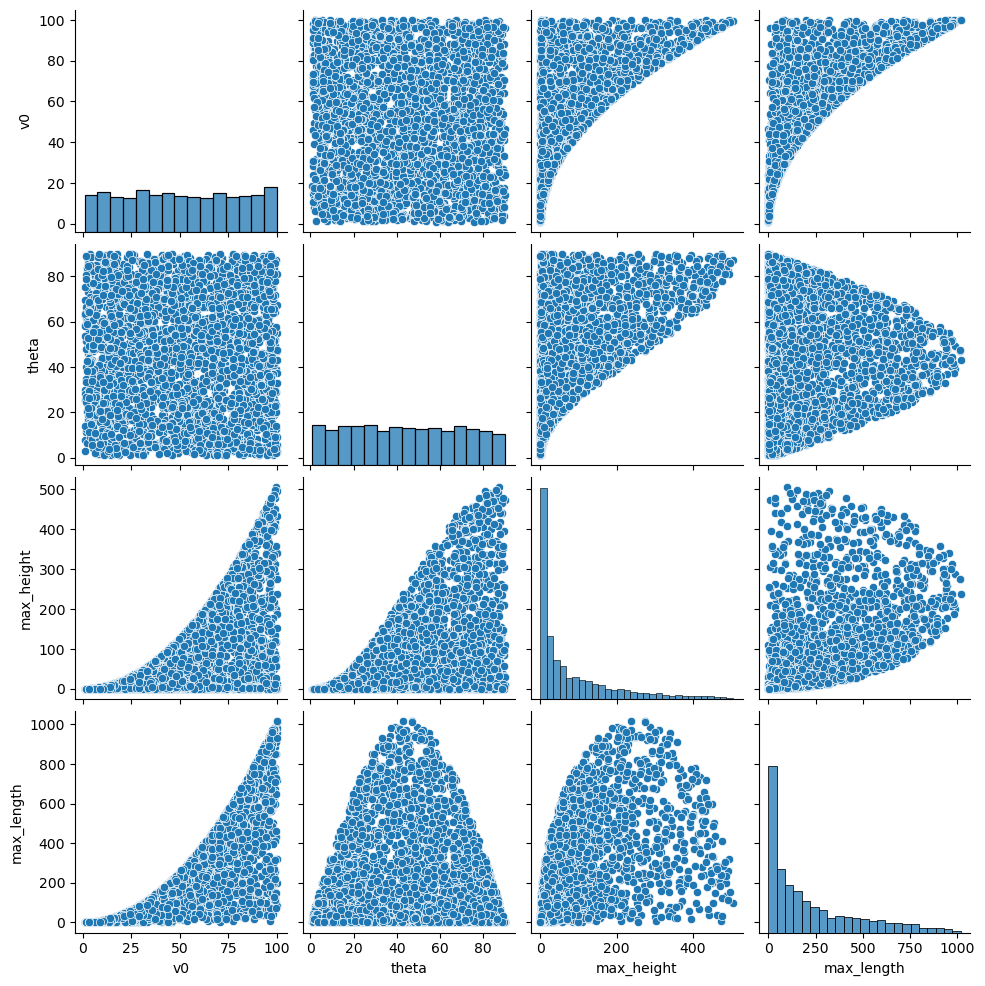

In [93]:
# pair plot
data = {'v0': v0, 'theta': theta, 'max_height': max_h, 'max_length': max_l}
data_f = pd.DataFrame(data)
sns.pairplot(data_f) # 可加上觀察敘述

<AxesSubplot:>

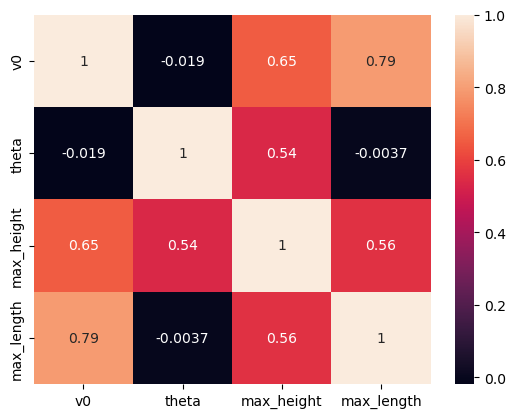

In [94]:
# correlation heatmap
sns.heatmap(data_f.corr(), annot=True)

# Functions and Classes

In [95]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
import time

# dataset
class Projectile_Dataset(Dataset):
    def __init__(self, x, y, train=None, pred_target='max_height'):
        if pred_target == 'max_height':
            y = y[:, 0]
        elif pred_target == 'max_length':
            y = y[:, 1]

        if train != None:
            # train test split
            x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)
            if train==True:
                x = x_train
                y = y_train
            else:
                x = x_test
                y = y_test
        
        # normalization
        scaler_x = MinMaxScaler()
        scaler_x.fit(x)
        x = scaler_x.transform(x)

        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        self.y = torch.from_numpy(y).type(torch.FloatTensor) # n_samples, 1
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples


# models
class MaxH_DNN(nn.Module):
    def __init__(self, activation_func='LeakyReLU'):
        super(MaxH_DNN, self).__init__()
        # 大約3層 改深度試看看
        if activation_func == 'ReLU':
            act = nn.ReLU()
        elif activation_func == 'LeakyReLU':
            act = nn.LeakyReLU()
        elif activation_func == 'Mish':
            act = nn.Mish()
        elif activation_func == 'Sigmoid':
            act = nn.Sigmoid()
        elif activation_func == 'Tanh':
            act = nn.Tanh()
        self.layer1 = nn.Sequential(nn.Linear(2, 16), act)
        self.layer2 = nn.Sequential(nn.Linear(16, 128), act)
        self.layer3 = nn.Sequential(nn.Linear(128, 64), act)
        self.layer4 = nn.Sequential(nn.Linear(64, 32), act)
        self.layer5 = nn.Sequential(nn.Linear(32, 8), act)
        self.layer6 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

class MaxL_DNN(nn.Module):
    def __init__(self, activation_func='LeakyReLU'):
        super(MaxL_DNN, self).__init__()
        if activation_func == 'ReLU':
            act = nn.ReLU()
        elif activation_func == 'LeakyReLU':
            act = nn.LeakyReLU()
        elif activation_func == 'Mish':
            act = nn.Mish()
        elif activation_func == 'Sigmoid':
            act = nn.Sigmoid()
        elif activation_func == 'Tanh':
            act = nn.Tanh()
        self.layer1 = nn.Sequential(nn.Linear(2, 16), act)
        self.layer2 = nn.Sequential(nn.Linear(16, 128), act)
        self.layer3 = nn.Sequential(nn.Linear(128, 256), act)
        self.layer4 = nn.Sequential(nn.Linear(256, 128), act)
        self.layer5 = nn.Sequential(nn.Linear(128, 64), act)
        self.layer6 = nn.Sequential(nn.Linear(64, 16), act)
        self.layer7 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return x


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='Checkpoints/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(model, train_loader, test_loader, num_epochs=500, lr=1e-2, weight_decay=1e-5, T_max=10, eta_min=1e-5, patience=20):
    """
    num_epochs : epochs 數量
    lr : 初始學習速率
    weight_decay : 權重衰退係數
    T_max : 調整學習速率的週期
    eta_min : 最小學習速率
    patience : 測試集誤差經過此數目epochs的學習後仍沒有改善誤差, 則停止訓練
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min) # 隨著學習調整 lr
    criterion = nn.MSELoss() # loss function

    start = time.time()

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    n_total_steps = len(train_loader)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # 使用 gpu 運算
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')
    model.to(device)

    for epoch in range(num_epochs):

        ##### Training loop #####
        model.train() # prep model for training
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            # forward
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
        # update lr
        scheduler.step()

        ##### Validation loop #####
        model.eval() # prep model for evaluation
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            valid_losses.append(loss.item())
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f'[Epoch {epoch+1}/{num_epochs}] train_loss: {train_loss:.2f}, valid_loss: {valid_loss:.2f}')

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('Checkpoints/checkpoint.pt'))
    
    end = time.time()
    print(f'Training is end. Total trainig time: {(end-start)/60:.1f} minutes')
    print(f'Best validation loss: {np.min(avg_valid_losses)}')

    return model, avg_train_losses, avg_valid_losses


def loss_plot(avg_train_losses, avg_test_losses):
    plt.figure()
    plt.plot(avg_train_losses, 'r-', label='train')
    plt.plot(avg_test_losses, 'b-', label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('recorded loss')
    plt.legend()
    plt.show()


def model_evaluate(model, train_loader, test_loader, pred_target='max_height'):
    """
    Using RMSE & r2 score as metrics
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')

    model = model.to(device).eval() # evaluation mode
    train_rmse_lst = []
    test_rmse_lst = []
    train_mape_lst = []
    test_mape_lst = []
    train_true_lst, train_pred_lst = [], []
    test_true_lst, test_pred_lst = [], []

    if pred_target == 'max_height':
        xlim, ylim = 0, 600
    elif pred_target == 'max_length':
        xlim, ylim = 0, 1100

    fig, ax = plt.subplots(figsize=(6, 6))
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)

            mape_train = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_train = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            train_rmse_lst.append(rmse_train.item())
            train_mape_lst.append(mape_train.item())
            train_true_lst.append(targets.tolist())
            train_pred_lst.append(outputs.tolist())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5, label='train')
            else:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5)
        
        print(f'Training set|RMSE: {np.average(train_rmse_lst):.2f}, R2: {np.average(train_mape_lst)}')

        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)
            
            mape_test = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_test = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            test_rmse_lst.append(rmse_test.item())
            test_mape_lst.append(mape_test.item())
            test_true_lst.append(targets.tolist())
            test_pred_lst.append(outputs.tolist())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5, label='valid')
            else:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5)

        print(f'Testing set|RMSE: {np.average(test_rmse_lst):.2f}, R2: {np.average(test_mape_lst)}')

        ax.set_title(pred_target)
        ax.set_xlim(xlim, ylim)
        ax.set_ylim(xlim, ylim)
        ax.plot([xlim, ylim], [xlim, ylim], 'k--', linewidth=1.5)
        ax.set_xlabel('predicted')
        ax.set_ylabel('ground truth')
        ax.legend()
        plt.savefig('Figures/'+pred_target+'.png')
        plt.show()
    
    return np.ravel(test_true_lst), np.ravel(test_pred_lst)


# 比較不同 activation function

ReLU
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 137.11, valid_loss: 108.99
Validation loss decreased (inf --> 108.988703).  Saving model ...
[Epoch 2/1000] train_loss: 104.56, valid_loss: 94.83
Validation loss decreased (108.988703 --> 94.827356).  Saving model ...
[Epoch 3/1000] train_loss: 82.30, valid_loss: 62.11
Validation loss decreased (94.827356 --> 62.112898).  Saving model ...
[Epoch 4/1000] train_loss: 34.63, valid_loss: 20.78
Validation loss decreased (62.112898 --> 20.783744).  Saving model ...
[Epoch 5/1000] train_loss: 16.98, valid_loss: 11.93
Validation loss decreased (20.783744 --> 11.930839).  Saving model ...
[Epoch 6/1000] train_loss: 11.67, valid_loss: 12.34
EarlyStopping counter: 1 out of 100
[Epoch 7/1000] train_loss: 11.29, valid_loss: 7.68
Validation loss decreased (11.930839 --> 7.682857).  Saving model ...
[Epoch 8/1000] train_loss: 8.75, valid_loss: 8.14
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 7.76, valid_loss: 6.96
Validation 

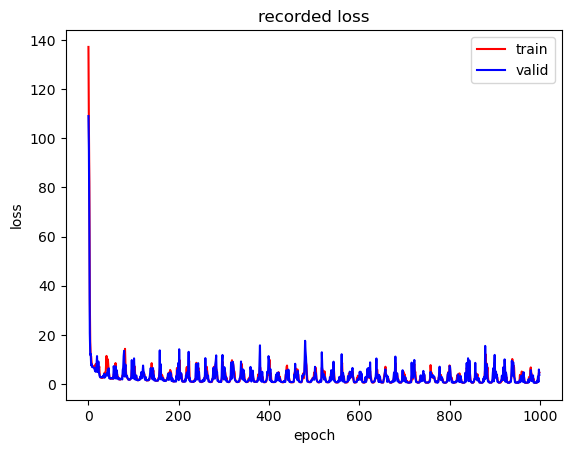

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 141.19, valid_loss: 117.47
Validation loss decreased (inf --> 117.471231).  Saving model ...
[Epoch 2/1000] train_loss: 110.65, valid_loss: 96.65
Validation loss decreased (117.471231 --> 96.646479).  Saving model ...
[Epoch 3/1000] train_loss: 98.67, valid_loss: 82.56
Validation loss decreased (96.646479 --> 82.555061).  Saving model ...
[Epoch 4/1000] train_loss: 84.35, valid_loss: 67.89
Validation loss decreased (82.555061 --> 67.892658).  Saving model ...
[Epoch 5/1000] train_loss: 58.24, valid_loss: 38.01
Validation loss decreased (67.892658 --> 38.009938).  Saving model ...
[Epoch 6/1000] train_loss: 31.33, valid_loss: 29.56
Validation loss decreased (38.009938 --> 29.555226).  Saving model ...
[Epoch 7/1000] train_loss: 28.31, valid_loss: 25.81
Validation loss decreased (29.555226 --> 25.812000).  Saving model ...
[Epoch 8/1000] train_loss: 25.65, valid_loss: 26.33
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 

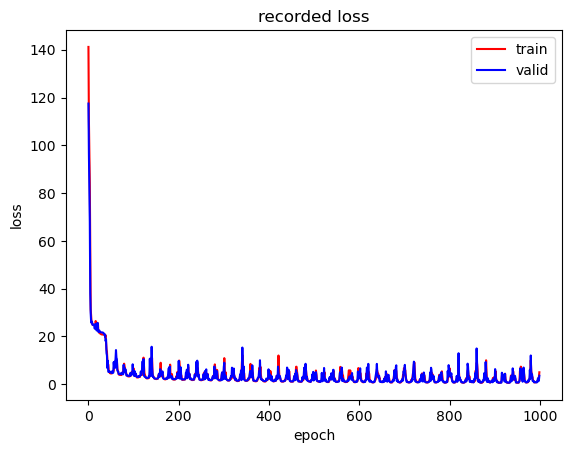

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 133.07, valid_loss: 104.50
Validation loss decreased (inf --> 104.504292).  Saving model ...
[Epoch 2/1000] train_loss: 93.08, valid_loss: 86.43
Validation loss decreased (104.504292 --> 86.425009).  Saving model ...
[Epoch 3/1000] train_loss: 63.92, valid_loss: 42.31
Validation loss decreased (86.425009 --> 42.313524).  Saving model ...
[Epoch 4/1000] train_loss: 25.80, valid_loss: 20.32
Validation loss decreased (42.313524 --> 20.315948).  Saving model ...
[Epoch 5/1000] train_loss: 16.35, valid_loss: 19.32
Validation loss decreased (20.315948 --> 19.320267).  Saving model ...
[Epoch 6/1000] train_loss: 14.63, valid_loss: 12.62
Validation loss decreased (19.320267 --> 12.615934).  Saving model ...
[Epoch 7/1000] train_loss: 10.64, valid_loss: 11.34
Validation loss decreased (12.615934 --> 11.339696).  Saving model ...
[Epoch 8/1000] train_loss: 9.16, valid_loss: 8.69
Validation loss decreased (11.339696 --> 8.690807).  Saving model 

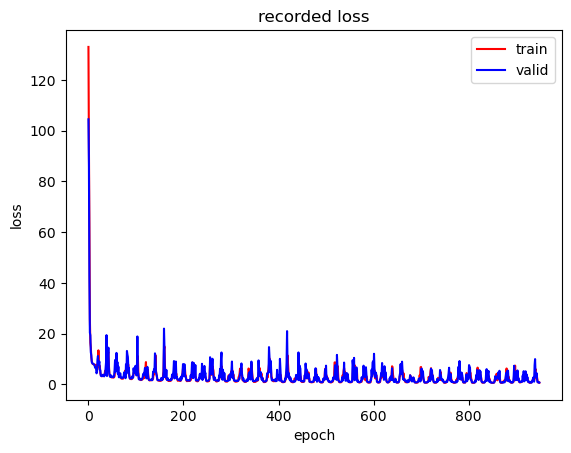

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 132.71, valid_loss: 115.77
Validation loss decreased (inf --> 115.767561).  Saving model ...
[Epoch 2/1000] train_loss: 104.38, valid_loss: 105.96
Validation loss decreased (115.767561 --> 105.958603).  Saving model ...
[Epoch 3/1000] train_loss: 93.32, valid_loss: 93.16
Validation loss decreased (105.958603 --> 93.159126).  Saving model ...
[Epoch 4/1000] train_loss: 77.58, valid_loss: 72.03
Validation loss decreased (93.159126 --> 72.025246).  Saving model ...
[Epoch 5/1000] train_loss: 49.66, valid_loss: 31.30
Validation loss decreased (72.025246 --> 31.303274).  Saving model ...
[Epoch 6/1000] train_loss: 25.74, valid_loss: 24.49
Validation loss decreased (31.303274 --> 24.494056).  Saving model ...
[Epoch 7/1000] train_loss: 22.56, valid_loss: 22.25
Validation loss decreased (24.494056 --> 22.253416).  Saving model ...
[Epoch 8/1000] train_loss: 20.76, valid_loss: 18.81
Validation loss decreased (22.253416 --> 18.808815).  Saving

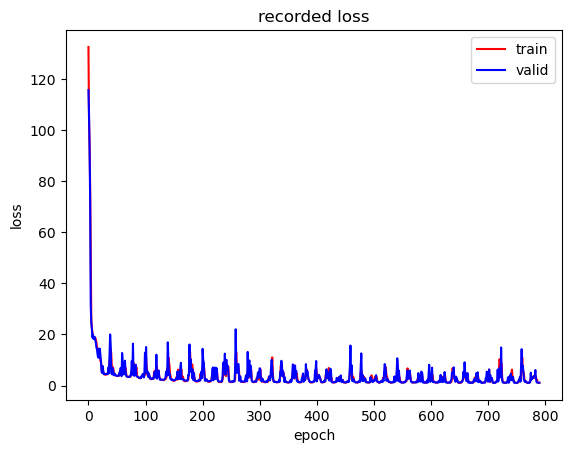

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 143.35, valid_loss: 130.14
Validation loss decreased (inf --> 130.135115).  Saving model ...
[Epoch 2/1000] train_loss: 109.08, valid_loss: 94.83
Validation loss decreased (130.135115 --> 94.831032).  Saving model ...
[Epoch 3/1000] train_loss: 94.43, valid_loss: 86.15
Validation loss decreased (94.831032 --> 86.145569).  Saving model ...
[Epoch 4/1000] train_loss: 81.22, valid_loss: 64.26
Validation loss decreased (86.145569 --> 64.257367).  Saving model ...
[Epoch 5/1000] train_loss: 53.72, valid_loss: 32.73
Validation loss decreased (64.257367 --> 32.732816).  Saving model ...
[Epoch 6/1000] train_loss: 29.08, valid_loss: 35.39
EarlyStopping counter: 1 out of 100
[Epoch 7/1000] train_loss: 27.17, valid_loss: 26.31
Validation loss decreased (32.732816 --> 26.307792).  Saving model ...
[Epoch 8/1000] train_loss: 24.84, valid_loss: 26.25
Validation loss decreased (26.307792 --> 26.246634).  Saving model ...
[Epoch 9/1000] train_loss: 

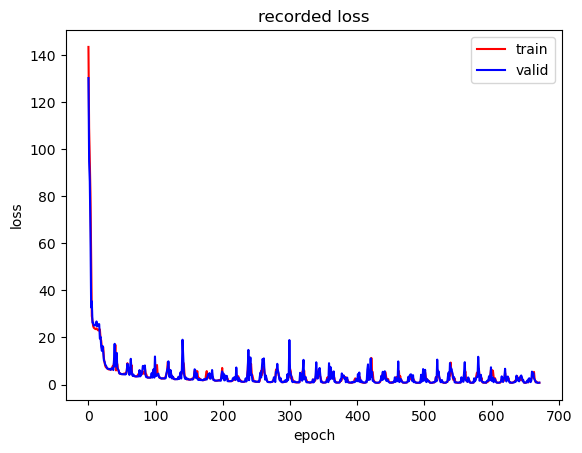

Averge RMSE performance: 0.7165070295333862
LeakyReLU
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 134.70, valid_loss: 103.30
Validation loss decreased (inf --> 103.295347).  Saving model ...
[Epoch 2/1000] train_loss: 101.63, valid_loss: 90.02
Validation loss decreased (103.295347 --> 90.019463).  Saving model ...
[Epoch 3/1000] train_loss: 83.34, valid_loss: 65.62
Validation loss decreased (90.019463 --> 65.618152).  Saving model ...
[Epoch 4/1000] train_loss: 50.34, valid_loss: 35.06
Validation loss decreased (65.618152 --> 35.060105).  Saving model ...
[Epoch 5/1000] train_loss: 27.48, valid_loss: 22.31
Validation loss decreased (35.060105 --> 22.306987).  Saving model ...
[Epoch 6/1000] train_loss: 24.04, valid_loss: 23.22
EarlyStopping counter: 1 out of 100
[Epoch 7/1000] train_loss: 21.50, valid_loss: 19.81
Validation loss decreased (22.306987 --> 19.813832).  Saving model ...
[Epoch 8/1000] train_loss: 18.87, valid_loss: 16.73
Validation loss decreased (19.813832 --> 16.

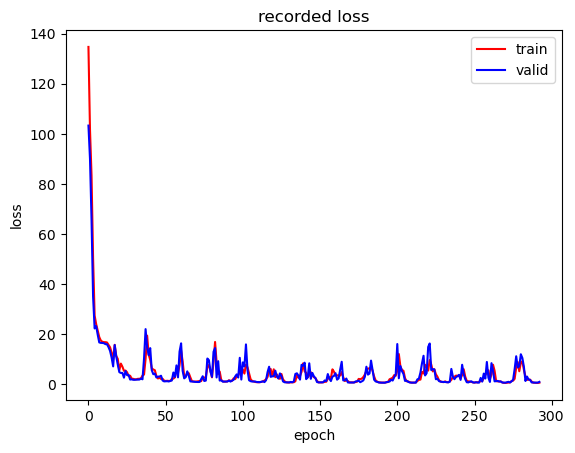

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 140.53, valid_loss: 99.58
Validation loss decreased (inf --> 99.583660).  Saving model ...
[Epoch 2/1000] train_loss: 99.43, valid_loss: 86.56
Validation loss decreased (99.583660 --> 86.563204).  Saving model ...
[Epoch 3/1000] train_loss: 85.21, valid_loss: 73.95
Validation loss decreased (86.563204 --> 73.949921).  Saving model ...
[Epoch 4/1000] train_loss: 58.87, valid_loss: 34.38
Validation loss decreased (73.949921 --> 34.380099).  Saving model ...
[Epoch 5/1000] train_loss: 28.54, valid_loss: 23.45
Validation loss decreased (34.380099 --> 23.447692).  Saving model ...
[Epoch 6/1000] train_loss: 21.94, valid_loss: 20.94
Validation loss decreased (23.447692 --> 20.940332).  Saving model ...
[Epoch 7/1000] train_loss: 20.47, valid_loss: 20.28
Validation loss decreased (20.940332 --> 20.284420).  Saving model ...
[Epoch 8/1000] train_loss: 19.62, valid_loss: 18.84
Validation loss decreased (20.284420 --> 18.843040).  Saving model 

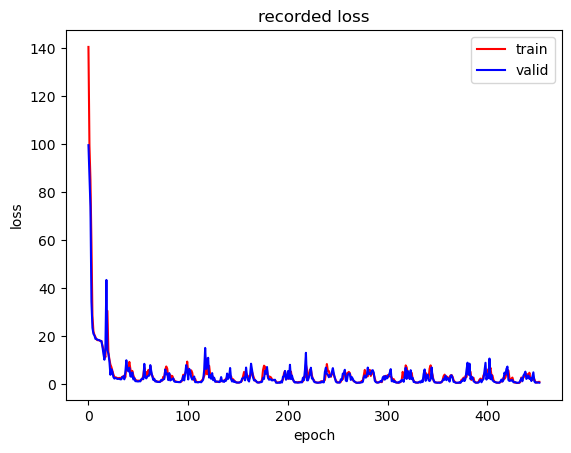

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 130.60, valid_loss: 105.88
Validation loss decreased (inf --> 105.878944).  Saving model ...
[Epoch 2/1000] train_loss: 98.99, valid_loss: 95.73
Validation loss decreased (105.878944 --> 95.731066).  Saving model ...
[Epoch 3/1000] train_loss: 83.57, valid_loss: 74.19
Validation loss decreased (95.731066 --> 74.190916).  Saving model ...
[Epoch 4/1000] train_loss: 48.48, valid_loss: 24.80
Validation loss decreased (74.190916 --> 24.802340).  Saving model ...
[Epoch 5/1000] train_loss: 22.95, valid_loss: 22.90
Validation loss decreased (24.802340 --> 22.898874).  Saving model ...
[Epoch 6/1000] train_loss: 20.03, valid_loss: 17.46
Validation loss decreased (22.898874 --> 17.459276).  Saving model ...
[Epoch 7/1000] train_loss: 15.96, valid_loss: 14.57
Validation loss decreased (17.459276 --> 14.569498).  Saving model ...
[Epoch 8/1000] train_loss: 12.66, valid_loss: 12.36
Validation loss decreased (14.569498 --> 12.362872).  Saving mod

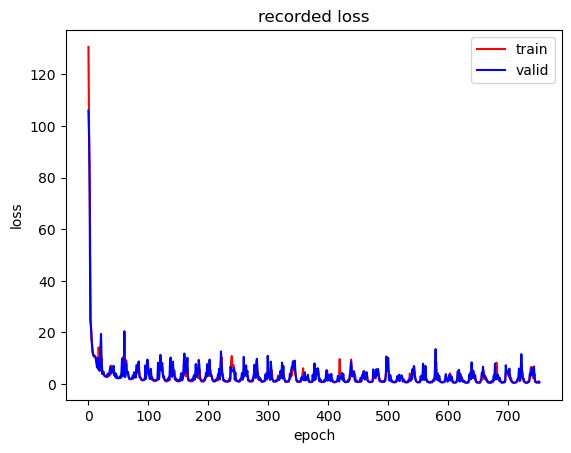

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 134.38, valid_loss: 109.89
Validation loss decreased (inf --> 109.893667).  Saving model ...
[Epoch 2/1000] train_loss: 97.15, valid_loss: 86.25
Validation loss decreased (109.893667 --> 86.248972).  Saving model ...
[Epoch 3/1000] train_loss: 62.95, valid_loss: 41.26
Validation loss decreased (86.248972 --> 41.262520).  Saving model ...
[Epoch 4/1000] train_loss: 30.54, valid_loss: 26.46
Validation loss decreased (41.262520 --> 26.456135).  Saving model ...
[Epoch 5/1000] train_loss: 27.25, valid_loss: 28.27
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 26.82, valid_loss: 24.25
Validation loss decreased (26.456135 --> 24.252161).  Saving model ...
[Epoch 7/1000] train_loss: 25.05, valid_loss: 25.04
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 24.51, valid_loss: 23.68
Validation loss decreased (24.252161 --> 23.683782).  Saving model ...
[Epoch 9/1000] train_loss: 23.91, valid_loss: 24.19
EarlyStoppi

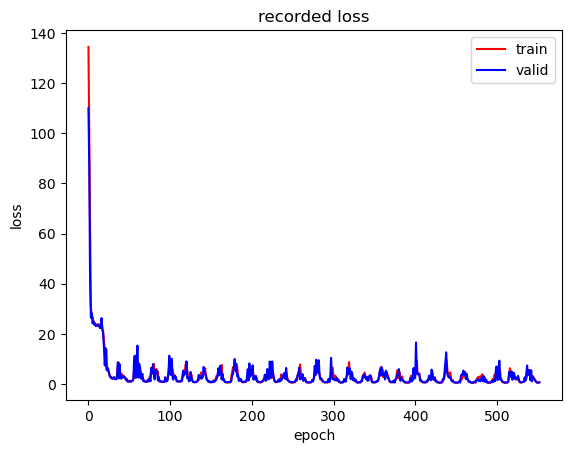

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 133.49, valid_loss: 100.37
Validation loss decreased (inf --> 100.368246).  Saving model ...
[Epoch 2/1000] train_loss: 96.54, valid_loss: 77.51
Validation loss decreased (100.368246 --> 77.505627).  Saving model ...
[Epoch 3/1000] train_loss: 61.98, valid_loss: 27.14
Validation loss decreased (77.505627 --> 27.143118).  Saving model ...
[Epoch 4/1000] train_loss: 29.15, valid_loss: 24.22
Validation loss decreased (27.143118 --> 24.215573).  Saving model ...
[Epoch 5/1000] train_loss: 21.73, valid_loss: 20.65
Validation loss decreased (24.215573 --> 20.650506).  Saving model ...
[Epoch 6/1000] train_loss: 18.34, valid_loss: 17.83
Validation loss decreased (20.650506 --> 17.834466).  Saving model ...
[Epoch 7/1000] train_loss: 16.01, valid_loss: 15.42
Validation loss decreased (17.834466 --> 15.416514).  Saving model ...
[Epoch 8/1000] train_loss: 14.26, valid_loss: 14.97
Validation loss decreased (15.416514 --> 14.973927).  Saving mod

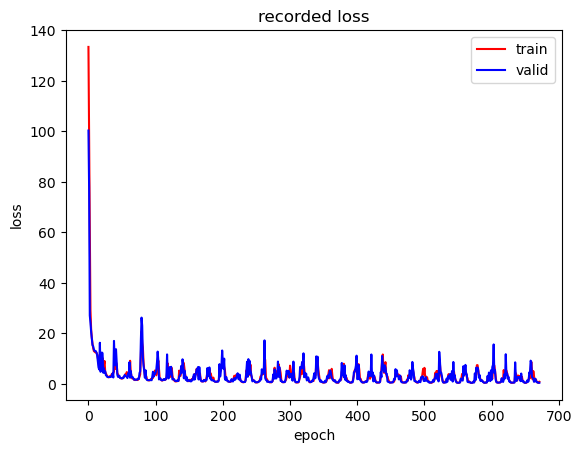

Averge RMSE performance: 0.549818654358387
Sigmoid
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 143.87, valid_loss: 138.99
Validation loss decreased (inf --> 138.994524).  Saving model ...
[Epoch 2/1000] train_loss: 143.64, valid_loss: 140.90
EarlyStopping counter: 1 out of 100
[Epoch 3/1000] train_loss: 142.15, valid_loss: 140.55
EarlyStopping counter: 2 out of 100
[Epoch 4/1000] train_loss: 141.83, valid_loss: 139.59
EarlyStopping counter: 3 out of 100
[Epoch 5/1000] train_loss: 142.18, valid_loss: 139.91
EarlyStopping counter: 4 out of 100
[Epoch 6/1000] train_loss: 142.38, valid_loss: 139.37
EarlyStopping counter: 5 out of 100
[Epoch 7/1000] train_loss: 141.37, valid_loss: 138.29
Validation loss decreased (138.994524 --> 138.292334).  Saving model ...
[Epoch 8/1000] train_loss: 141.02, valid_loss: 139.18
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 141.11, valid_loss: 138.81
EarlyStopping counter: 2 out of 100
[Epoch 10/1000] train_loss: 141.23, valid_loss:

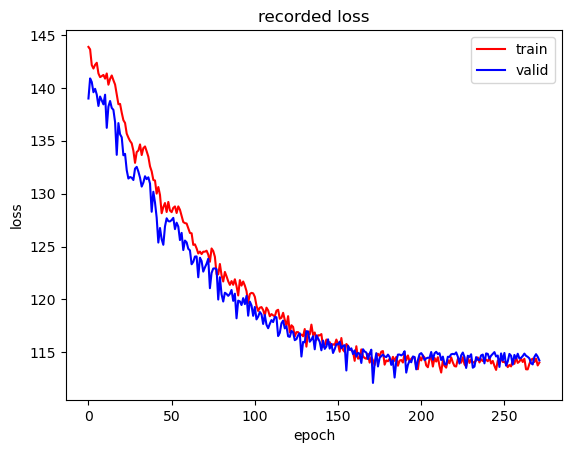

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 145.46, valid_loss: 135.13
Validation loss decreased (inf --> 135.126698).  Saving model ...
[Epoch 2/1000] train_loss: 144.74, valid_loss: 134.47
Validation loss decreased (135.126698 --> 134.470642).  Saving model ...
[Epoch 3/1000] train_loss: 144.33, valid_loss: 134.32
Validation loss decreased (134.470642 --> 134.322947).  Saving model ...
[Epoch 4/1000] train_loss: 143.55, valid_loss: 132.44
Validation loss decreased (134.322947 --> 132.436033).  Saving model ...
[Epoch 5/1000] train_loss: 143.28, valid_loss: 133.93
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 142.01, valid_loss: 130.82
Validation loss decreased (132.436033 --> 130.816488).  Saving model ...
[Epoch 7/1000] train_loss: 142.63, valid_loss: 130.80
Validation loss decreased (130.816488 --> 130.799685).  Saving model ...
[Epoch 8/1000] train_loss: 141.94, valid_loss: 132.60
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 142.26, valid

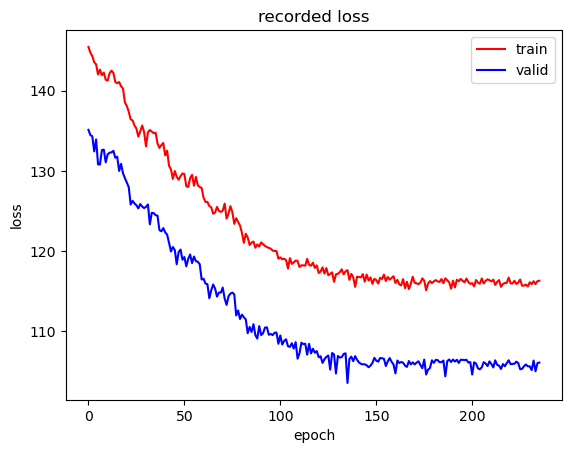

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 140.89, valid_loss: 154.53
Validation loss decreased (inf --> 154.525845).  Saving model ...
[Epoch 2/1000] train_loss: 139.39, valid_loss: 153.92
Validation loss decreased (154.525845 --> 153.919559).  Saving model ...
[Epoch 3/1000] train_loss: 139.75, valid_loss: 149.22
Validation loss decreased (153.919559 --> 149.223763).  Saving model ...
[Epoch 4/1000] train_loss: 137.22, valid_loss: 150.65
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 136.96, valid_loss: 150.33
EarlyStopping counter: 2 out of 100
[Epoch 6/1000] train_loss: 137.01, valid_loss: 151.64
EarlyStopping counter: 3 out of 100
[Epoch 7/1000] train_loss: 137.13, valid_loss: 149.41
EarlyStopping counter: 4 out of 100
[Epoch 8/1000] train_loss: 135.59, valid_loss: 150.39
EarlyStopping counter: 5 out of 100
[Epoch 9/1000] train_loss: 136.78, valid_loss: 151.03
EarlyStopping counter: 6 out of 100
[Epoch 10/1000] train_loss: 136.19, valid_loss: 149.20
Valida

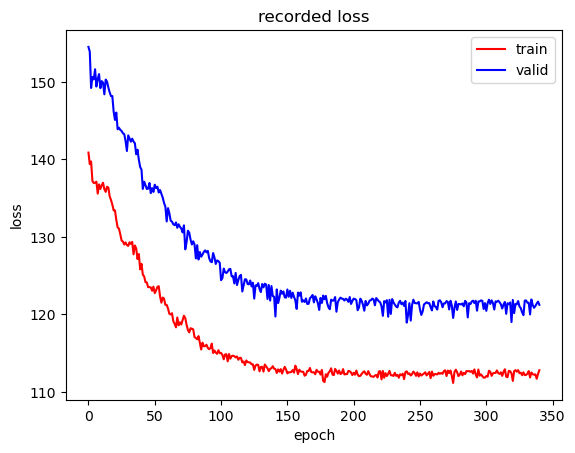

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 142.68, valid_loss: 146.15
Validation loss decreased (inf --> 146.149586).  Saving model ...
[Epoch 2/1000] train_loss: 141.84, valid_loss: 145.77
Validation loss decreased (146.149586 --> 145.770226).  Saving model ...
[Epoch 3/1000] train_loss: 142.01, valid_loss: 145.55
Validation loss decreased (145.770226 --> 145.545479).  Saving model ...
[Epoch 4/1000] train_loss: 140.56, valid_loss: 144.27
Validation loss decreased (145.545479 --> 144.271326).  Saving model ...
[Epoch 5/1000] train_loss: 139.92, valid_loss: 144.79
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 139.36, valid_loss: 144.17
Validation loss decreased (144.271326 --> 144.171261).  Saving model ...
[Epoch 7/1000] train_loss: 139.54, valid_loss: 142.80
Validation loss decreased (144.171261 --> 142.797461).  Saving model ...
[Epoch 8/1000] train_loss: 138.74, valid_loss: 142.30
Validation loss decreased (142.797461 --> 142.303148).  Saving model ...
[Ep

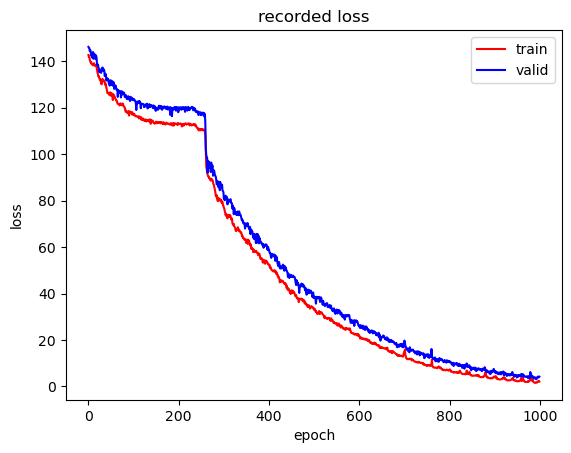

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 144.82, valid_loss: 140.31
Validation loss decreased (inf --> 140.309563).  Saving model ...
[Epoch 2/1000] train_loss: 142.89, valid_loss: 139.49
Validation loss decreased (140.309563 --> 139.486958).  Saving model ...
[Epoch 3/1000] train_loss: 143.24, valid_loss: 138.77
Validation loss decreased (139.486958 --> 138.765198).  Saving model ...
[Epoch 4/1000] train_loss: 142.84, valid_loss: 137.56
Validation loss decreased (138.765198 --> 137.559309).  Saving model ...
[Epoch 5/1000] train_loss: 142.69, valid_loss: 134.11
Validation loss decreased (137.559309 --> 134.105686).  Saving model ...
[Epoch 6/1000] train_loss: 141.45, valid_loss: 137.50
EarlyStopping counter: 1 out of 100
[Epoch 7/1000] train_loss: 142.05, valid_loss: 136.01
EarlyStopping counter: 2 out of 100
[Epoch 8/1000] train_loss: 140.37, valid_loss: 136.44
EarlyStopping counter: 3 out of 100
[Epoch 9/1000] train_loss: 141.74, valid_loss: 135.76
EarlyStopping counter: 

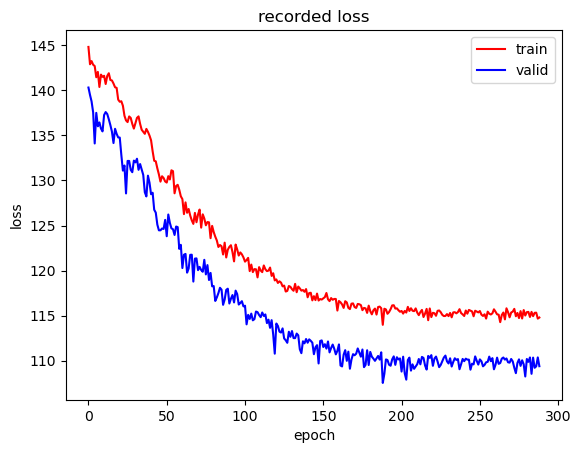

Averge RMSE performance: 89.04804716706276
Mish
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 131.30, valid_loss: 117.12
Validation loss decreased (inf --> 117.122961).  Saving model ...
[Epoch 2/1000] train_loss: 102.88, valid_loss: 102.80
Validation loss decreased (117.122961 --> 102.801180).  Saving model ...
[Epoch 3/1000] train_loss: 89.85, valid_loss: 73.10
Validation loss decreased (102.801180 --> 73.104290).  Saving model ...
[Epoch 4/1000] train_loss: 49.96, valid_loss: 26.67
Validation loss decreased (73.104290 --> 26.665453).  Saving model ...
[Epoch 5/1000] train_loss: 32.48, valid_loss: 26.06
Validation loss decreased (26.665453 --> 26.063570).  Saving model ...
[Epoch 6/1000] train_loss: 23.28, valid_loss: 20.40
Validation loss decreased (26.063570 --> 20.398331).  Saving model ...
[Epoch 7/1000] train_loss: 21.05, valid_loss: 18.83
Validation loss decreased (20.398331 --> 18.832725).  Saving model ...
[Epoch 8/1000] train_loss: 19.39, valid_loss: 17.58
Validation l

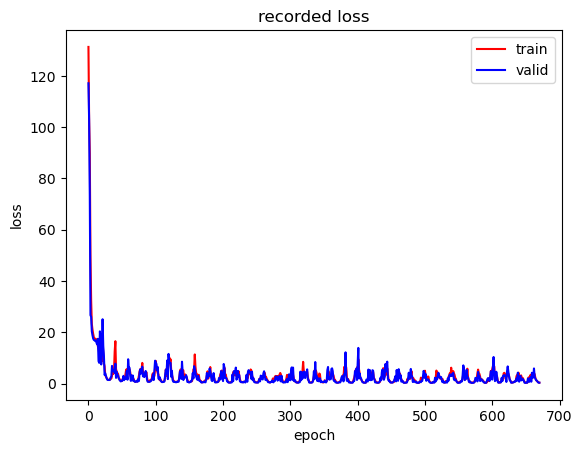

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 129.67, valid_loss: 121.81
Validation loss decreased (inf --> 121.810307).  Saving model ...
[Epoch 2/1000] train_loss: 108.22, valid_loss: 94.72
Validation loss decreased (121.810307 --> 94.718420).  Saving model ...
[Epoch 3/1000] train_loss: 84.93, valid_loss: 58.89
Validation loss decreased (94.718420 --> 58.887991).  Saving model ...
[Epoch 4/1000] train_loss: 41.60, valid_loss: 39.21
Validation loss decreased (58.887991 --> 39.208115).  Saving model ...
[Epoch 5/1000] train_loss: 33.67, valid_loss: 39.09
Validation loss decreased (39.208115 --> 39.094985).  Saving model ...
[Epoch 6/1000] train_loss: 29.30, valid_loss: 25.82
Validation loss decreased (39.094985 --> 25.824965).  Saving model ...
[Epoch 7/1000] train_loss: 25.99, valid_loss: 25.16
Validation loss decreased (25.824965 --> 25.162615).  Saving model ...
[Epoch 8/1000] train_loss: 24.84, valid_loss: 23.60
Validation loss decreased (25.162615 --> 23.597128).  Saving mo

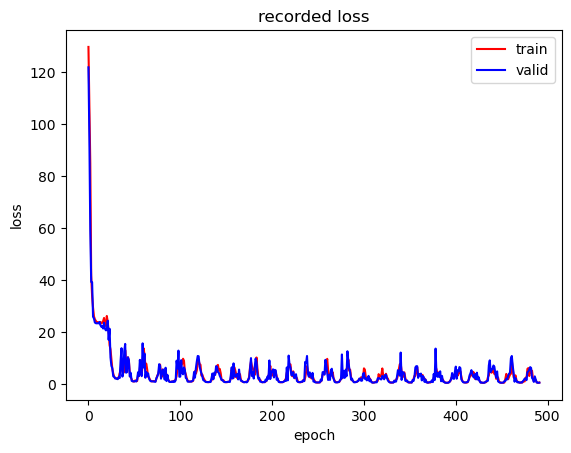

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 133.35, valid_loss: 110.56
Validation loss decreased (inf --> 110.558968).  Saving model ...
[Epoch 2/1000] train_loss: 103.19, valid_loss: 96.01
Validation loss decreased (110.558968 --> 96.014830).  Saving model ...
[Epoch 3/1000] train_loss: 86.39, valid_loss: 76.61
Validation loss decreased (96.014830 --> 76.606125).  Saving model ...
[Epoch 4/1000] train_loss: 57.49, valid_loss: 32.25
Validation loss decreased (76.606125 --> 32.248262).  Saving model ...
[Epoch 5/1000] train_loss: 29.12, valid_loss: 34.40
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 29.74, valid_loss: 29.82
Validation loss decreased (32.248262 --> 29.816172).  Saving model ...
[Epoch 7/1000] train_loss: 27.51, valid_loss: 28.93
Validation loss decreased (29.816172 --> 28.928831).  Saving model ...
[Epoch 8/1000] train_loss: 25.85, valid_loss: 25.50
Validation loss decreased (28.928831 --> 25.497621).  Saving model ...
[Epoch 9/1000] train_loss: 

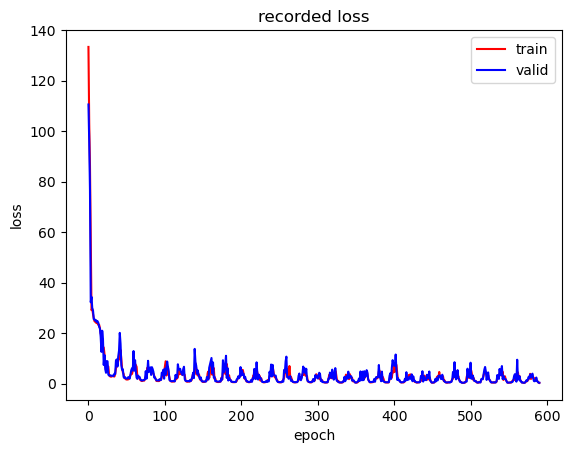

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 130.18, valid_loss: 106.92
Validation loss decreased (inf --> 106.919004).  Saving model ...
[Epoch 2/1000] train_loss: 93.07, valid_loss: 83.77
Validation loss decreased (106.919004 --> 83.769533).  Saving model ...
[Epoch 3/1000] train_loss: 62.76, valid_loss: 52.02
Validation loss decreased (83.769533 --> 52.016037).  Saving model ...
[Epoch 4/1000] train_loss: 33.43, valid_loss: 30.85
Validation loss decreased (52.016037 --> 30.851622).  Saving model ...
[Epoch 5/1000] train_loss: 27.32, valid_loss: 25.31
Validation loss decreased (30.851622 --> 25.308863).  Saving model ...
[Epoch 6/1000] train_loss: 24.94, valid_loss: 23.53
Validation loss decreased (25.308863 --> 23.528079).  Saving model ...
[Epoch 7/1000] train_loss: 24.35, valid_loss: 22.80
Validation loss decreased (23.528079 --> 22.798316).  Saving model ...
[Epoch 8/1000] train_loss: 23.59, valid_loss: 22.00
Validation loss decreased (22.798316 --> 22.004084).  Saving mod

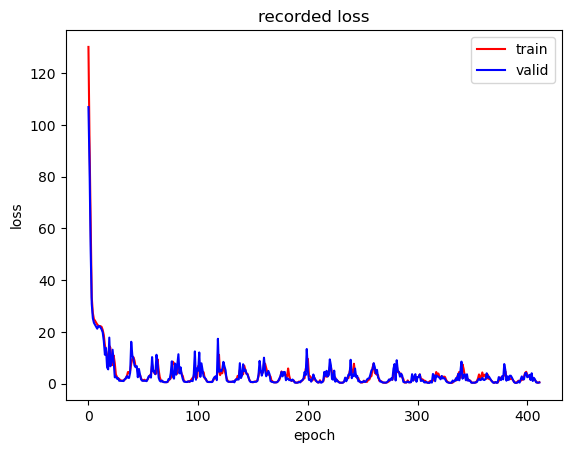

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 129.22, valid_loss: 100.41
Validation loss decreased (inf --> 100.407547).  Saving model ...
[Epoch 2/1000] train_loss: 88.28, valid_loss: 66.84
Validation loss decreased (100.407547 --> 66.840822).  Saving model ...
[Epoch 3/1000] train_loss: 54.56, valid_loss: 40.83
Validation loss decreased (66.840822 --> 40.833123).  Saving model ...
[Epoch 4/1000] train_loss: 35.41, valid_loss: 28.63
Validation loss decreased (40.833123 --> 28.626492).  Saving model ...
[Epoch 5/1000] train_loss: 29.03, valid_loss: 27.08
Validation loss decreased (28.626492 --> 27.075569).  Saving model ...
[Epoch 6/1000] train_loss: 25.06, valid_loss: 25.78
Validation loss decreased (27.075569 --> 25.782565).  Saving model ...
[Epoch 7/1000] train_loss: 24.29, valid_loss: 25.93
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 23.59, valid_loss: 26.38
EarlyStopping counter: 2 out of 100
[Epoch 9/1000] train_loss: 23.54, valid_loss: 24.66
Validation 

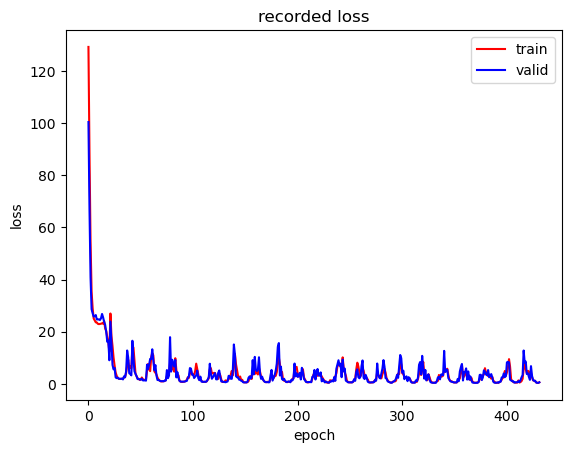

Averge RMSE performance: 0.3403103411197662
Tanh
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 143.86, valid_loss: 139.58
Validation loss decreased (inf --> 139.580164).  Saving model ...
[Epoch 2/1000] train_loss: 141.79, valid_loss: 140.13
EarlyStopping counter: 1 out of 100
[Epoch 3/1000] train_loss: 141.71, valid_loss: 136.79
Validation loss decreased (139.580164 --> 136.790297).  Saving model ...
[Epoch 4/1000] train_loss: 140.73, valid_loss: 137.94
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 140.17, valid_loss: 137.43
EarlyStopping counter: 2 out of 100
[Epoch 6/1000] train_loss: 139.34, valid_loss: 137.24
EarlyStopping counter: 3 out of 100
[Epoch 7/1000] train_loss: 138.34, valid_loss: 133.56
Validation loss decreased (136.790297 --> 133.557106).  Saving model ...
[Epoch 8/1000] train_loss: 138.01, valid_loss: 136.35
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 138.83, valid_loss: 136.80
EarlyStopping counter: 2 out of 100
[Epoch 10/10

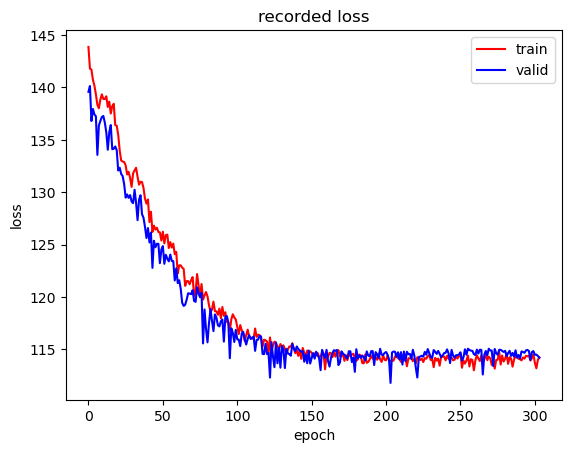

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 145.07, valid_loss: 134.43
Validation loss decreased (inf --> 134.425968).  Saving model ...
[Epoch 2/1000] train_loss: 142.41, valid_loss: 134.01
Validation loss decreased (134.425968 --> 134.007107).  Saving model ...
[Epoch 3/1000] train_loss: 142.70, valid_loss: 133.27
Validation loss decreased (134.007107 --> 133.271227).  Saving model ...
[Epoch 4/1000] train_loss: 142.34, valid_loss: 133.47
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 142.30, valid_loss: 132.35
Validation loss decreased (133.271227 --> 132.351254).  Saving model ...
[Epoch 6/1000] train_loss: 141.95, valid_loss: 132.23
Validation loss decreased (132.351254 --> 132.233746).  Saving model ...
[Epoch 7/1000] train_loss: 140.11, valid_loss: 132.02
Validation loss decreased (132.233746 --> 132.018499).  Saving model ...
[Epoch 8/1000] train_loss: 140.18, valid_loss: 131.49
Validation loss decreased (132.018499 --> 131.494122).  Saving model ...
[Ep

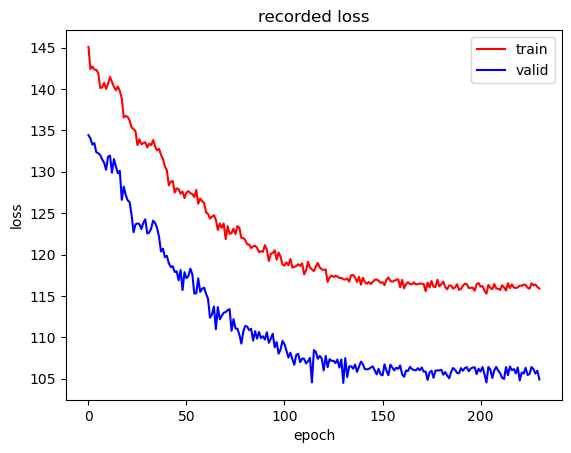

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 139.88, valid_loss: 153.09
Validation loss decreased (inf --> 153.094091).  Saving model ...
[Epoch 2/1000] train_loss: 139.21, valid_loss: 153.36
EarlyStopping counter: 1 out of 100
[Epoch 3/1000] train_loss: 138.71, valid_loss: 152.71
Validation loss decreased (153.094091 --> 152.707275).  Saving model ...
[Epoch 4/1000] train_loss: 137.42, valid_loss: 151.61
Validation loss decreased (152.707275 --> 151.612164).  Saving model ...
[Epoch 5/1000] train_loss: 137.07, valid_loss: 151.47
Validation loss decreased (151.612164 --> 151.473484).  Saving model ...
[Epoch 6/1000] train_loss: 137.48, valid_loss: 150.87
Validation loss decreased (151.473484 --> 150.865986).  Saving model ...
[Epoch 7/1000] train_loss: 136.56, valid_loss: 149.61
Validation loss decreased (150.865986 --> 149.605881).  Saving model ...
[Epoch 8/1000] train_loss: 135.72, valid_loss: 149.93
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 136.56, valid

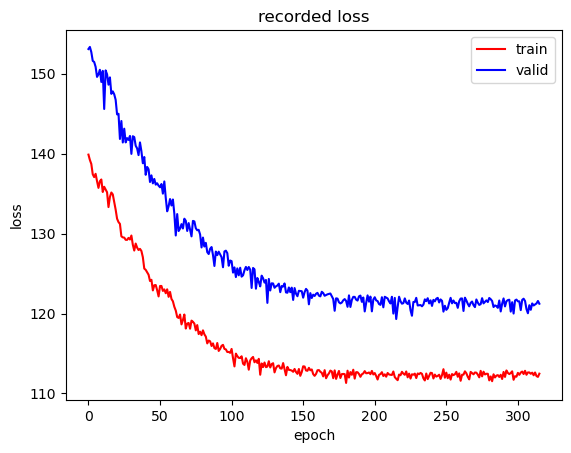

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 141.74, valid_loss: 144.94
Validation loss decreased (inf --> 144.935587).  Saving model ...
[Epoch 2/1000] train_loss: 139.98, valid_loss: 142.58
Validation loss decreased (144.935587 --> 142.575701).  Saving model ...
[Epoch 3/1000] train_loss: 138.97, valid_loss: 142.85
EarlyStopping counter: 1 out of 100
[Epoch 4/1000] train_loss: 138.54, valid_loss: 143.18
EarlyStopping counter: 2 out of 100
[Epoch 5/1000] train_loss: 138.60, valid_loss: 142.63
EarlyStopping counter: 3 out of 100
[Epoch 6/1000] train_loss: 138.14, valid_loss: 141.83
Validation loss decreased (142.575701 --> 141.832346).  Saving model ...
[Epoch 7/1000] train_loss: 137.72, valid_loss: 142.59
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 137.15, valid_loss: 141.69
Validation loss decreased (141.832346 --> 141.685070).  Saving model ...
[Epoch 9/1000] train_loss: 137.06, valid_loss: 141.98
EarlyStopping counter: 1 out of 100
[Epoch 10/1000] train_lo

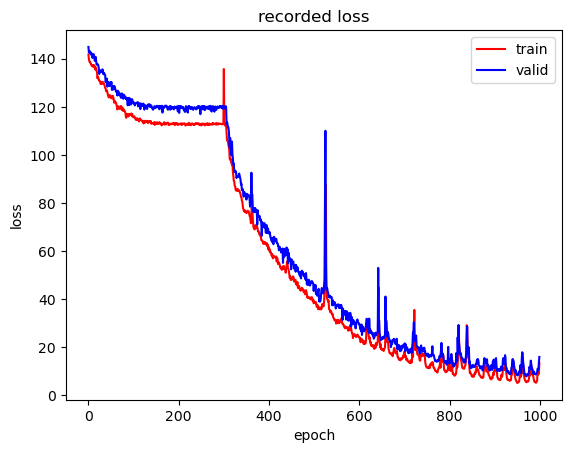

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 143.58, valid_loss: 137.28
Validation loss decreased (inf --> 137.276041).  Saving model ...
[Epoch 2/1000] train_loss: 142.95, valid_loss: 136.24
Validation loss decreased (137.276041 --> 136.242285).  Saving model ...
[Epoch 3/1000] train_loss: 142.31, valid_loss: 136.66
EarlyStopping counter: 1 out of 100
[Epoch 4/1000] train_loss: 140.73, valid_loss: 136.44
EarlyStopping counter: 2 out of 100
[Epoch 5/1000] train_loss: 139.93, valid_loss: 134.49
Validation loss decreased (136.242285 --> 134.489567).  Saving model ...
[Epoch 6/1000] train_loss: 140.30, valid_loss: 135.61
EarlyStopping counter: 1 out of 100
[Epoch 7/1000] train_loss: 139.48, valid_loss: 134.77
EarlyStopping counter: 2 out of 100
[Epoch 8/1000] train_loss: 139.91, valid_loss: 134.67
EarlyStopping counter: 3 out of 100
[Epoch 9/1000] train_loss: 140.04, valid_loss: 134.29
Validation loss decreased (134.489567 --> 134.290573).  Saving model ...
[Epoch 10/1000] train_lo

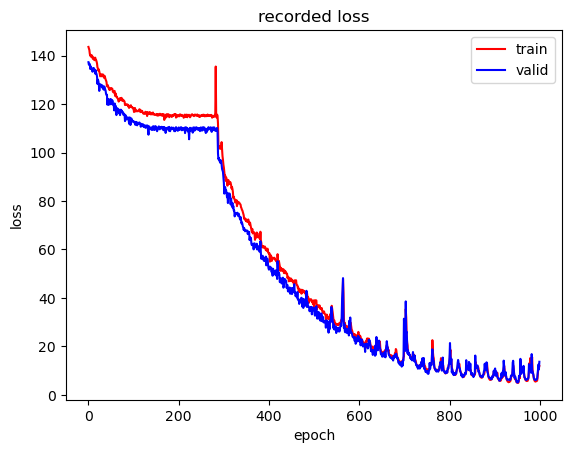

Averge RMSE performance: 69.69457882642746


In [ ]:
# load dataset
train_dataset = Projectile_Dataset(X, Y, pred_target='max_height')
test_dataset = Projectile_Dataset(X, Y, pred_target='max_height')

act_func_lst = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Mish', 'Tanh']
avg_loss_lst = []

for activation_func in act_func_lst:
    # Kfold
    splits=KFold(n_splits=5, shuffle=True, random_state=100)
    kfold_history = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

    print(activation_func)
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(X.shape[0]))):
        print(f'Fold {fold+1}')

        # initiate data loader
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(train_dataset, batch_size=50, sampler=train_sampler) # batch_size : 要分批餵入模型的資料大小
        test_loader = DataLoader(test_dataset, batch_size=50, sampler=test_sampler)

        # initiate model
        maxh_model = MaxH_DNN(activation_func=activation_func)

        # train
        saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

        # draw loss plot
        loss_plot(train_loss, valid_loss)

        # save history
        kfold_history['model'].append(saved_model)
        kfold_history['train_idx'].append(train_idx)
        kfold_history['test_idx'].append(val_idx)
        kfold_history['train_min_loss'].append(np.min(train_loss))
        kfold_history['test_min_loss'].append(np.min(valid_loss))
    avg_rmse = np.mean(kfold_history['test_min_loss'])
    avg_loss_lst.append(avg_rmse)
    print('Averge RMSE performance: '+str(avg_rmse))

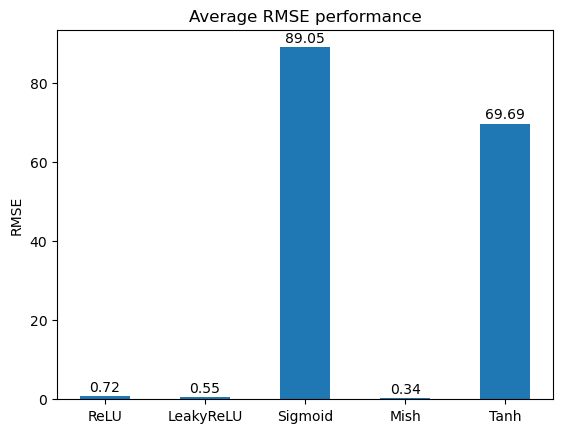

In [ ]:
plt.figure()
plt.bar(act_func_lst, avg_loss_lst, width=0.5)
for a,b in zip(act_func_lst, avg_loss_lst):
    plt.text(a, b+0.5, '%.2f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title('Average RMSE performance')
plt.ylabel('RMSE')
plt.show()

# 比較不同資料量

Size: 100
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 126.34, valid_loss: 94.87
Validation loss decreased (inf --> 94.869934).  Saving model ...
[Epoch 2/1000] train_loss: 124.30, valid_loss: 93.58
Validation loss decreased (94.869934 --> 93.580063).  Saving model ...
[Epoch 3/1000] train_loss: 120.73, valid_loss: 90.45
Validation loss decreased (93.580063 --> 90.448769).  Saving model ...
[Epoch 4/1000] train_loss: 123.40, valid_loss: 84.81
Validation loss decreased (90.448769 --> 84.809395).  Saving model ...
[Epoch 5/1000] train_loss: 117.11, valid_loss: 76.99
Validation loss decreased (84.809395 --> 76.988159).  Saving model ...
[Epoch 6/1000] train_loss: 107.39, valid_loss: 68.63
Validation loss decreased (76.988159 --> 68.628555).  Saving model ...
[Epoch 7/1000] train_loss: 100.77, valid_loss: 62.00
Validation loss decreased (68.628555 --> 62.000248).  Saving model ...
[Epoch 8/1000] train_loss: 99.01, valid_loss: 58.34
Validation loss decreased (62.000248 --> 58.336090)

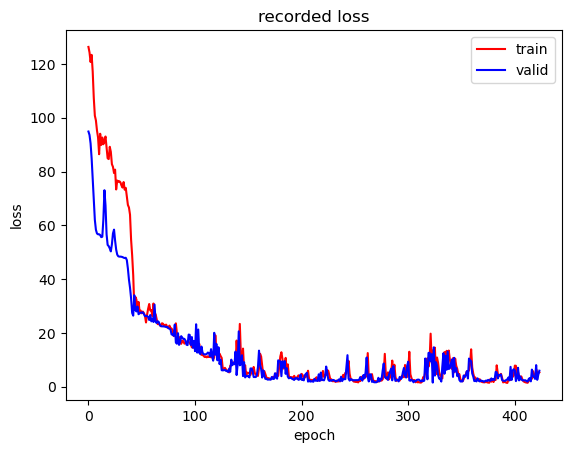

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 119.64, valid_loss: 144.59
Validation loss decreased (inf --> 144.585907).  Saving model ...
[Epoch 2/1000] train_loss: 115.51, valid_loss: 144.00
Validation loss decreased (144.585907 --> 144.002808).  Saving model ...
[Epoch 3/1000] train_loss: 110.70, valid_loss: 142.48
Validation loss decreased (144.002808 --> 142.478439).  Saving model ...
[Epoch 4/1000] train_loss: 113.98, valid_loss: 139.48
Validation loss decreased (142.478439 --> 139.481445).  Saving model ...
[Epoch 5/1000] train_loss: 111.38, valid_loss: 134.90
Validation loss decreased (139.481445 --> 134.904907).  Saving model ...
[Epoch 6/1000] train_loss: 108.25, valid_loss: 129.40
Validation loss decreased (134.904907 --> 129.404739).  Saving model ...
[Epoch 7/1000] train_loss: 97.50, valid_loss: 124.23
Validation loss decreased (129.404739 --> 124.232117).  Saving model ...
[Epoch 8/1000] train_loss: 97.47, valid_loss: 120.51
Validation loss decreased (124.232117 -->

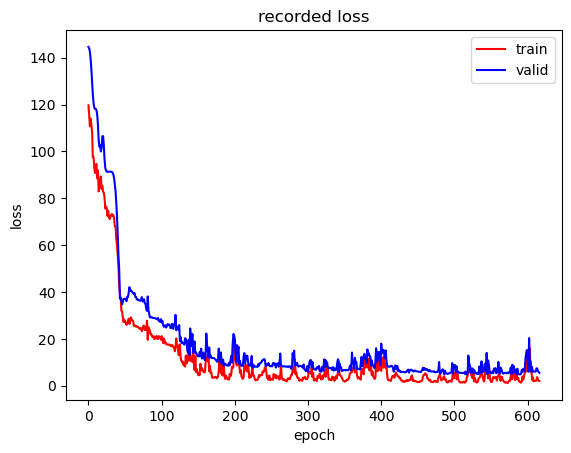

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 103.81, valid_loss: 168.67
Validation loss decreased (inf --> 168.666138).  Saving model ...
[Epoch 2/1000] train_loss: 110.65, valid_loss: 168.46
Validation loss decreased (168.666138 --> 168.464096).  Saving model ...
[Epoch 3/1000] train_loss: 99.37, valid_loss: 168.02
Validation loss decreased (168.464096 --> 168.016602).  Saving model ...
[Epoch 4/1000] train_loss: 109.51, valid_loss: 167.12
Validation loss decreased (168.016602 --> 167.123932).  Saving model ...
[Epoch 5/1000] train_loss: 106.13, valid_loss: 165.72
Validation loss decreased (167.123932 --> 165.718140).  Saving model ...
[Epoch 6/1000] train_loss: 105.73, valid_loss: 163.95
Validation loss decreased (165.718140 --> 163.954224).  Saving model ...
[Epoch 7/1000] train_loss: 102.68, valid_loss: 162.20
Validation loss decreased (163.954224 --> 162.195450).  Saving model ...
[Epoch 8/1000] train_loss: 99.73, valid_loss: 160.84
Validation loss decreased (162.195450 -->

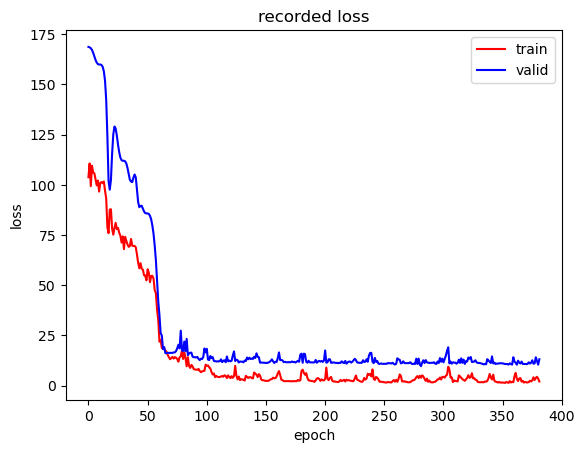

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 126.71, valid_loss: 115.72
Validation loss decreased (inf --> 115.723465).  Saving model ...
[Epoch 2/1000] train_loss: 126.22, valid_loss: 115.08
Validation loss decreased (115.723465 --> 115.078880).  Saving model ...
[Epoch 3/1000] train_loss: 125.90, valid_loss: 113.56
Validation loss decreased (115.078880 --> 113.561302).  Saving model ...
[Epoch 4/1000] train_loss: 114.97, valid_loss: 110.79
Validation loss decreased (113.561302 --> 110.792915).  Saving model ...
[Epoch 5/1000] train_loss: 113.39, valid_loss: 106.76
Validation loss decreased (110.792915 --> 106.756836).  Saving model ...
[Epoch 6/1000] train_loss: 117.68, valid_loss: 102.04
Validation loss decreased (106.756836 --> 102.043884).  Saving model ...
[Epoch 7/1000] train_loss: 105.98, valid_loss: 97.72
Validation loss decreased (102.043884 --> 97.717438).  Saving model ...
[Epoch 8/1000] train_loss: 102.25, valid_loss: 94.65
Validation loss decreased (97.717438 --> 9

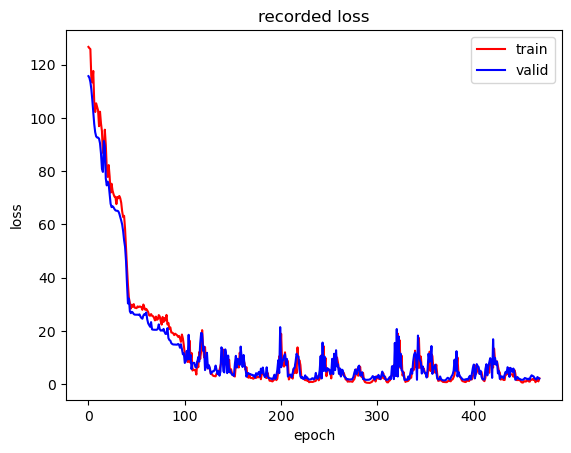

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 134.29, valid_loss: 58.18
Validation loss decreased (inf --> 58.175388).  Saving model ...
[Epoch 2/1000] train_loss: 128.76, valid_loss: 57.92
Validation loss decreased (58.175388 --> 57.915710).  Saving model ...
[Epoch 3/1000] train_loss: 134.36, valid_loss: 57.29
Validation loss decreased (57.915710 --> 57.290115).  Saving model ...
[Epoch 4/1000] train_loss: 133.80, valid_loss: 56.13
Validation loss decreased (57.290115 --> 56.131535).  Saving model ...
[Epoch 5/1000] train_loss: 125.86, valid_loss: 54.45
Validation loss decreased (56.131535 --> 54.452774).  Saving model ...
[Epoch 6/1000] train_loss: 125.22, valid_loss: 52.54
Validation loss decreased (54.452774 --> 52.539631).  Saving model ...
[Epoch 7/1000] train_loss: 127.14, valid_loss: 50.84
Validation loss decreased (52.539631 --> 50.839245).  Saving model ...
[Epoch 8/1000] train_loss: 124.82, valid_loss: 49.67
Validation loss decreased (50.839245 --> 49.673107).  Saving

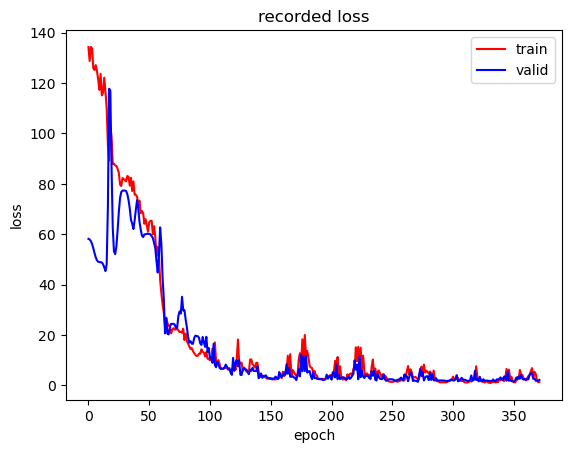

Averge RMSE performance: 3.7680503606796263
Size: 500
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 143.17, valid_loss: 105.42
Validation loss decreased (inf --> 105.416584).  Saving model ...
[Epoch 2/1000] train_loss: 133.05, valid_loss: 74.99
Validation loss decreased (105.416584 --> 74.988680).  Saving model ...
[Epoch 3/1000] train_loss: 103.95, valid_loss: 81.84
EarlyStopping counter: 1 out of 100
[Epoch 4/1000] train_loss: 94.04, valid_loss: 70.53
Validation loss decreased (74.988680 --> 70.532719).  Saving model ...
[Epoch 5/1000] train_loss: 91.97, valid_loss: 79.45
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 89.34, valid_loss: 70.75
EarlyStopping counter: 2 out of 100
[Epoch 7/1000] train_loss: 85.05, valid_loss: 68.61
Validation loss decreased (70.532719 --> 68.609131).  Saving model ...
[Epoch 8/1000] train_loss: 82.53, valid_loss: 69.50
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 81.32, valid_loss: 69.26
EarlyStopping counter: 2 

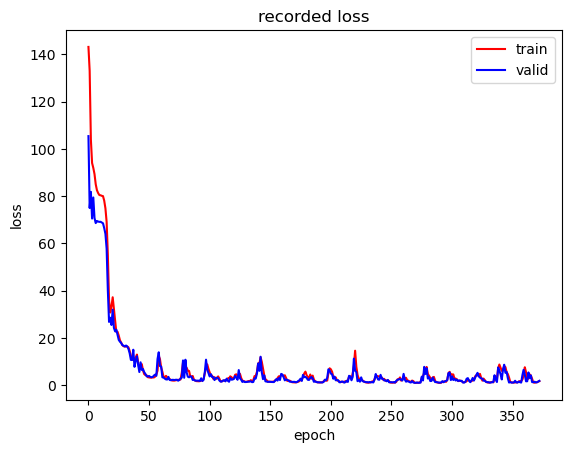

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 133.27, valid_loss: 150.34
Validation loss decreased (inf --> 150.341766).  Saving model ...
[Epoch 2/1000] train_loss: 118.24, valid_loss: 110.70
Validation loss decreased (150.341766 --> 110.696590).  Saving model ...
[Epoch 3/1000] train_loss: 97.44, valid_loss: 111.16
EarlyStopping counter: 1 out of 100
[Epoch 4/1000] train_loss: 93.87, valid_loss: 101.88
Validation loss decreased (110.696590 --> 101.877060).  Saving model ...
[Epoch 5/1000] train_loss: 86.53, valid_loss: 94.36
Validation loss decreased (101.877060 --> 94.361622).  Saving model ...
[Epoch 6/1000] train_loss: 80.13, valid_loss: 87.76
Validation loss decreased (94.361622 --> 87.762592).  Saving model ...
[Epoch 7/1000] train_loss: 73.70, valid_loss: 82.76
Validation loss decreased (87.762592 --> 82.761875).  Saving model ...
[Epoch 8/1000] train_loss: 69.36, valid_loss: 77.43
Validation loss decreased (82.761875 --> 77.434574).  Saving model ...
[Epoch 9/1000] train

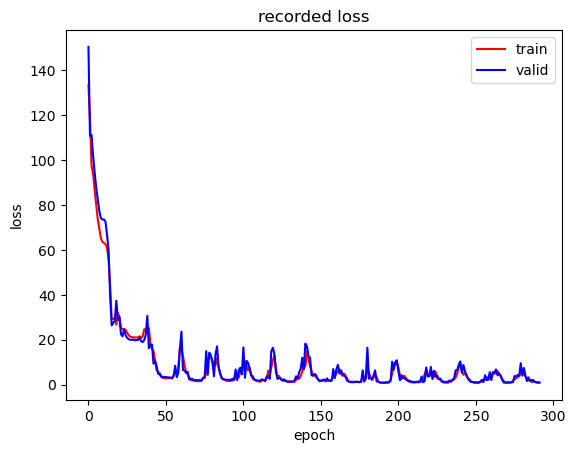

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 137.02, valid_loss: 136.13
Validation loss decreased (inf --> 136.134796).  Saving model ...
[Epoch 2/1000] train_loss: 125.26, valid_loss: 110.56
Validation loss decreased (136.134796 --> 110.556629).  Saving model ...
[Epoch 3/1000] train_loss: 105.31, valid_loss: 100.63
Validation loss decreased (110.556629 --> 100.634815).  Saving model ...
[Epoch 4/1000] train_loss: 96.15, valid_loss: 99.26
Validation loss decreased (100.634815 --> 99.261387).  Saving model ...
[Epoch 5/1000] train_loss: 93.76, valid_loss: 91.53
Validation loss decreased (99.261387 --> 91.526348).  Saving model ...
[Epoch 6/1000] train_loss: 88.86, valid_loss: 88.67
Validation loss decreased (91.526348 --> 88.672180).  Saving model ...
[Epoch 7/1000] train_loss: 86.13, valid_loss: 86.07
Validation loss decreased (88.672180 --> 86.069592).  Saving model ...
[Epoch 8/1000] train_loss: 84.18, valid_loss: 85.33
Validation loss decreased (86.069592 --> 85.329231).  Sa

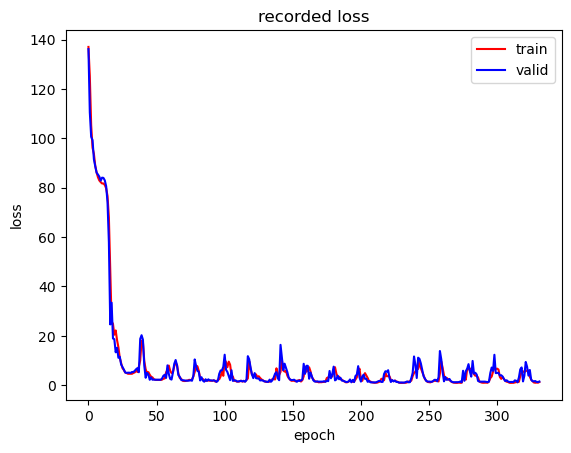

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 134.40, valid_loss: 140.47
Validation loss decreased (inf --> 140.465706).  Saving model ...
[Epoch 2/1000] train_loss: 115.60, valid_loss: 95.95
Validation loss decreased (140.465706 --> 95.951920).  Saving model ...
[Epoch 3/1000] train_loss: 97.75, valid_loss: 94.28
Validation loss decreased (95.951920 --> 94.278294).  Saving model ...
[Epoch 4/1000] train_loss: 89.92, valid_loss: 81.79
Validation loss decreased (94.278294 --> 81.793840).  Saving model ...
[Epoch 5/1000] train_loss: 84.38, valid_loss: 77.63
Validation loss decreased (81.793840 --> 77.628529).  Saving model ...
[Epoch 6/1000] train_loss: 78.83, valid_loss: 73.86
Validation loss decreased (77.628529 --> 73.864525).  Saving model ...
[Epoch 7/1000] train_loss: 74.86, valid_loss: 68.71
Validation loss decreased (73.864525 --> 68.711678).  Saving model ...
[Epoch 8/1000] train_loss: 70.69, valid_loss: 62.55
Validation loss decreased (68.711678 --> 62.553621).  Saving mo

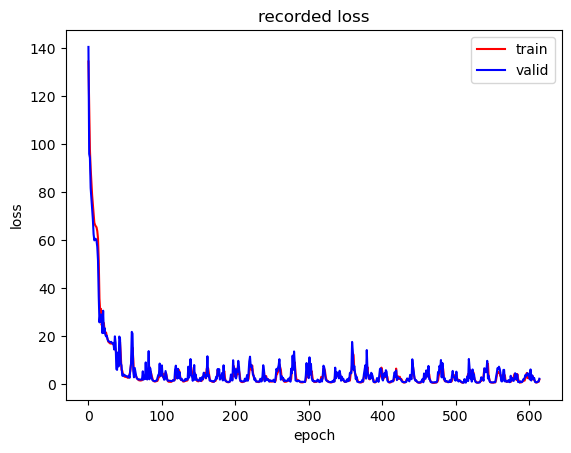

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 136.00, valid_loss: 139.18
Validation loss decreased (inf --> 139.176178).  Saving model ...
[Epoch 2/1000] train_loss: 124.00, valid_loss: 104.91
Validation loss decreased (139.176178 --> 104.909512).  Saving model ...
[Epoch 3/1000] train_loss: 100.64, valid_loss: 99.32
Validation loss decreased (104.909512 --> 99.319363).  Saving model ...
[Epoch 4/1000] train_loss: 95.50, valid_loss: 96.78
Validation loss decreased (99.319363 --> 96.782345).  Saving model ...
[Epoch 5/1000] train_loss: 89.02, valid_loss: 92.98
Validation loss decreased (96.782345 --> 92.980251).  Saving model ...
[Epoch 6/1000] train_loss: 86.09, valid_loss: 89.01
Validation loss decreased (92.980251 --> 89.010395).  Saving model ...
[Epoch 7/1000] train_loss: 82.17, valid_loss: 85.87
Validation loss decreased (89.010395 --> 85.867142).  Saving model ...
[Epoch 8/1000] train_loss: 78.61, valid_loss: 83.41
Validation loss decreased (85.867142 --> 83.411915).  Savin

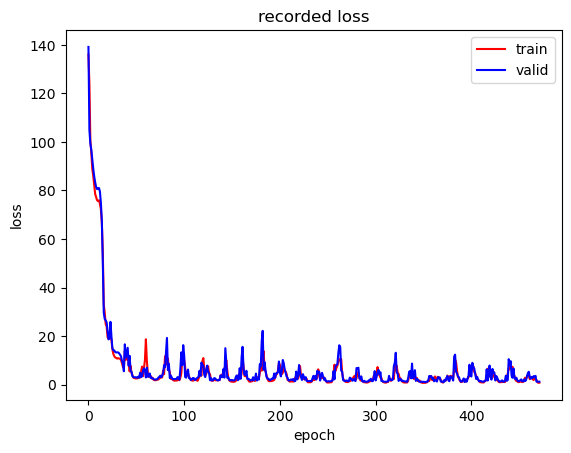

Averge RMSE performance: 0.9349737286567688
Size: 1000
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 138.46, valid_loss: 112.27
Validation loss decreased (inf --> 112.272943).  Saving model ...
[Epoch 2/1000] train_loss: 107.89, valid_loss: 100.53
Validation loss decreased (112.272943 --> 100.526693).  Saving model ...
[Epoch 3/1000] train_loss: 93.05, valid_loss: 80.58
Validation loss decreased (100.526693 --> 80.581587).  Saving model ...
[Epoch 4/1000] train_loss: 60.58, valid_loss: 28.44
Validation loss decreased (80.581587 --> 28.442413).  Saving model ...
[Epoch 5/1000] train_loss: 29.52, valid_loss: 25.20
Validation loss decreased (28.442413 --> 25.196747).  Saving model ...
[Epoch 6/1000] train_loss: 26.39, valid_loss: 24.11
Validation loss decreased (25.196747 --> 24.106866).  Saving model ...
[Epoch 7/1000] train_loss: 24.25, valid_loss: 24.18
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 24.04, valid_loss: 22.39
Validation loss decreased (24.106866 -->

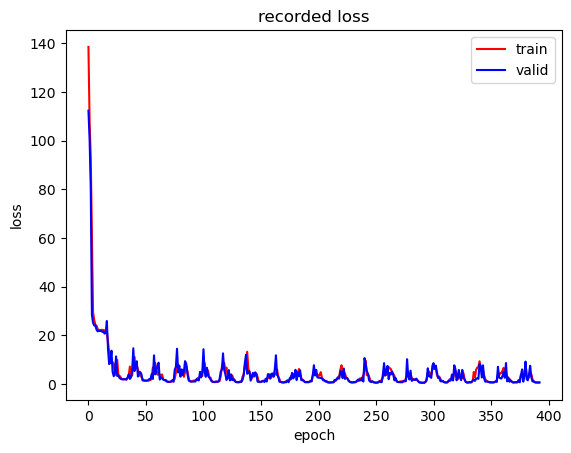

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 144.42, valid_loss: 122.14
Validation loss decreased (inf --> 122.139383).  Saving model ...
[Epoch 2/1000] train_loss: 110.95, valid_loss: 88.10
Validation loss decreased (122.139383 --> 88.102026).  Saving model ...
[Epoch 3/1000] train_loss: 82.65, valid_loss: 47.94
Validation loss decreased (88.102026 --> 47.944656).  Saving model ...
[Epoch 4/1000] train_loss: 32.01, valid_loss: 28.30
Validation loss decreased (47.944656 --> 28.304761).  Saving model ...
[Epoch 5/1000] train_loss: 24.19, valid_loss: 22.74
Validation loss decreased (28.304761 --> 22.739760).  Saving model ...
[Epoch 6/1000] train_loss: 19.28, valid_loss: 16.37
Validation loss decreased (22.739760 --> 16.374389).  Saving model ...
[Epoch 7/1000] train_loss: 15.13, valid_loss: 13.32
Validation loss decreased (16.374389 --> 13.323577).  Saving model ...
[Epoch 8/1000] train_loss: 12.56, valid_loss: 11.88
Validation loss decreased (13.323577 --> 11.875798).  Saving mo

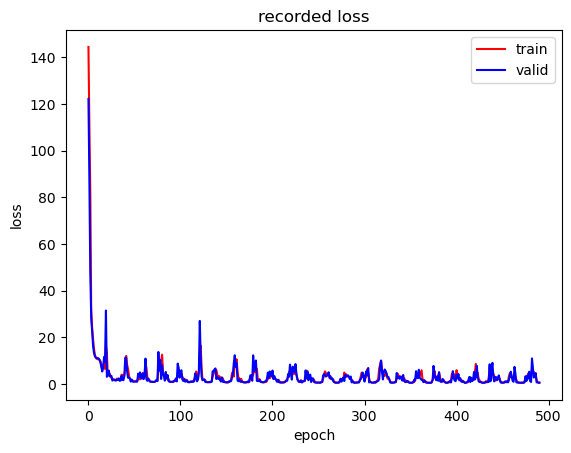

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 131.21, valid_loss: 110.31
Validation loss decreased (inf --> 110.311106).  Saving model ...
[Epoch 2/1000] train_loss: 97.08, valid_loss: 91.38
Validation loss decreased (110.311106 --> 91.381369).  Saving model ...
[Epoch 3/1000] train_loss: 75.98, valid_loss: 58.23
Validation loss decreased (91.381369 --> 58.227767).  Saving model ...
[Epoch 4/1000] train_loss: 38.10, valid_loss: 28.95
Validation loss decreased (58.227767 --> 28.952909).  Saving model ...
[Epoch 5/1000] train_loss: 29.57, valid_loss: 22.68
Validation loss decreased (28.952909 --> 22.677877).  Saving model ...
[Epoch 6/1000] train_loss: 22.19, valid_loss: 20.26
Validation loss decreased (22.677877 --> 20.258790).  Saving model ...
[Epoch 7/1000] train_loss: 18.94, valid_loss: 18.37
Validation loss decreased (20.258790 --> 18.372000).  Saving model ...
[Epoch 8/1000] train_loss: 17.24, valid_loss: 17.31
Validation loss decreased (18.372000 --> 17.309155).  Saving mod

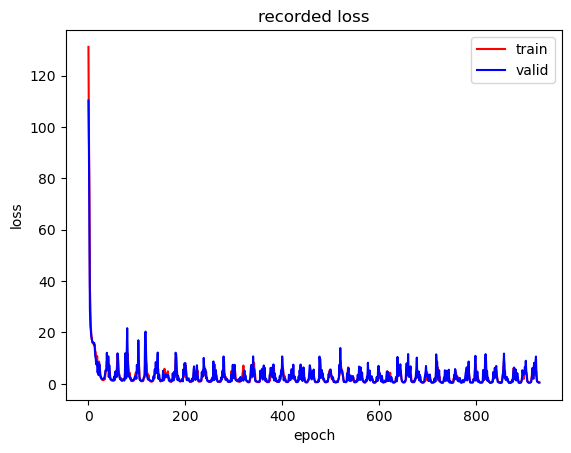

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 139.85, valid_loss: 121.57
Validation loss decreased (inf --> 121.573061).  Saving model ...
[Epoch 2/1000] train_loss: 103.27, valid_loss: 101.51
Validation loss decreased (121.573061 --> 101.510023).  Saving model ...
[Epoch 3/1000] train_loss: 88.97, valid_loss: 87.80
Validation loss decreased (101.510023 --> 87.804888).  Saving model ...
[Epoch 4/1000] train_loss: 75.93, valid_loss: 62.70
Validation loss decreased (87.804888 --> 62.699357).  Saving model ...
[Epoch 5/1000] train_loss: 37.97, valid_loss: 26.08
Validation loss decreased (62.699357 --> 26.077204).  Saving model ...
[Epoch 6/1000] train_loss: 23.99, valid_loss: 21.58
Validation loss decreased (26.077204 --> 21.584886).  Saving model ...
[Epoch 7/1000] train_loss: 19.98, valid_loss: 19.56
Validation loss decreased (21.584886 --> 19.557243).  Saving model ...
[Epoch 8/1000] train_loss: 17.87, valid_loss: 16.75
Validation loss decreased (19.557243 --> 16.753607).  Saving

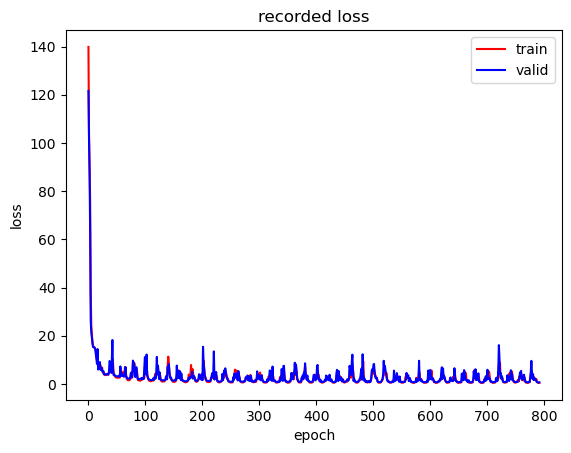

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 144.58, valid_loss: 140.34
Validation loss decreased (inf --> 140.343025).  Saving model ...
[Epoch 2/1000] train_loss: 125.64, valid_loss: 98.37
Validation loss decreased (140.343025 --> 98.367840).  Saving model ...
[Epoch 3/1000] train_loss: 90.61, valid_loss: 76.40
Validation loss decreased (98.367840 --> 76.402477).  Saving model ...
[Epoch 4/1000] train_loss: 73.64, valid_loss: 58.53
Validation loss decreased (76.402477 --> 58.529783).  Saving model ...
[Epoch 5/1000] train_loss: 50.33, valid_loss: 33.24
Validation loss decreased (58.529783 --> 33.235933).  Saving model ...
[Epoch 6/1000] train_loss: 29.36, valid_loss: 29.49
Validation loss decreased (33.235933 --> 29.493404).  Saving model ...
[Epoch 7/1000] train_loss: 23.46, valid_loss: 23.80
Validation loss decreased (29.493404 --> 23.796090).  Saving model ...
[Epoch 8/1000] train_loss: 22.00, valid_loss: 21.87
Validation loss decreased (23.796090 --> 21.873552).  Saving mo

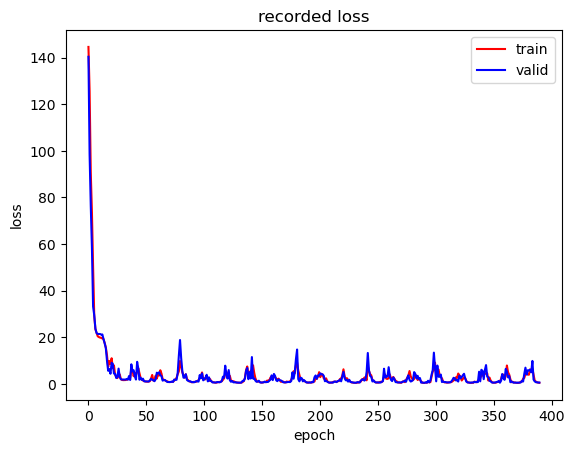

Averge RMSE performance: 0.5281293496489525
Size: 3000
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 104.73, valid_loss: 70.39
Validation loss decreased (inf --> 70.391276).  Saving model ...
[Epoch 2/1000] train_loss: 29.93, valid_loss: 15.54
Validation loss decreased (70.391276 --> 15.535248).  Saving model ...
[Epoch 3/1000] train_loss: 11.75, valid_loss: 5.99
Validation loss decreased (15.535248 --> 5.989264).  Saving model ...
[Epoch 4/1000] train_loss: 5.63, valid_loss: 4.29
Validation loss decreased (5.989264 --> 4.289194).  Saving model ...
[Epoch 5/1000] train_loss: 4.94, valid_loss: 5.60
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 7.01, valid_loss: 3.67
Validation loss decreased (4.289194 --> 3.672481).  Saving model ...
[Epoch 7/1000] train_loss: 2.87, valid_loss: 3.46
Validation loss decreased (3.672481 --> 3.458293).  Saving model ...
[Epoch 8/1000] train_loss: 2.22, valid_loss: 1.59
Validation loss decreased (3.458293 --> 1.588545).  Saving model 

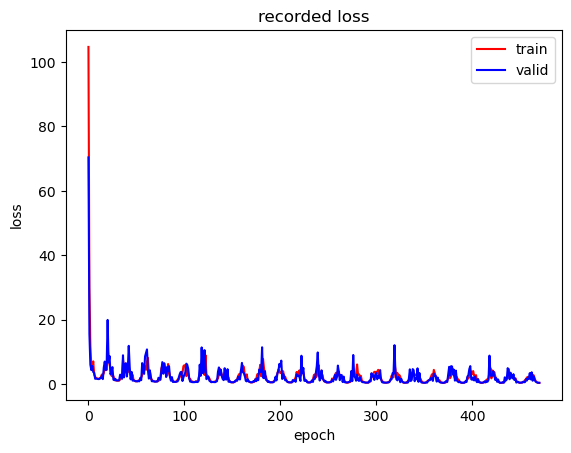

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 103.94, valid_loss: 73.37
Validation loss decreased (inf --> 73.368911).  Saving model ...
[Epoch 2/1000] train_loss: 34.72, valid_loss: 24.24
Validation loss decreased (73.368911 --> 24.241614).  Saving model ...
[Epoch 3/1000] train_loss: 24.13, valid_loss: 21.28
Validation loss decreased (24.241614 --> 21.284484).  Saving model ...
[Epoch 4/1000] train_loss: 22.61, valid_loss: 21.16
Validation loss decreased (21.284484 --> 21.162705).  Saving model ...
[Epoch 5/1000] train_loss: 15.27, valid_loss: 12.06
Validation loss decreased (21.162705 --> 12.059229).  Saving model ...
[Epoch 6/1000] train_loss: 6.47, valid_loss: 5.68
Validation loss decreased (12.059229 --> 5.677585).  Saving model ...
[Epoch 7/1000] train_loss: 3.33, valid_loss: 2.71
Validation loss decreased (5.677585 --> 2.706152).  Saving model ...
[Epoch 8/1000] train_loss: 2.43, valid_loss: 2.56
Validation loss decreased (2.706152 --> 2.560631).  Saving model ...
[Epoch 

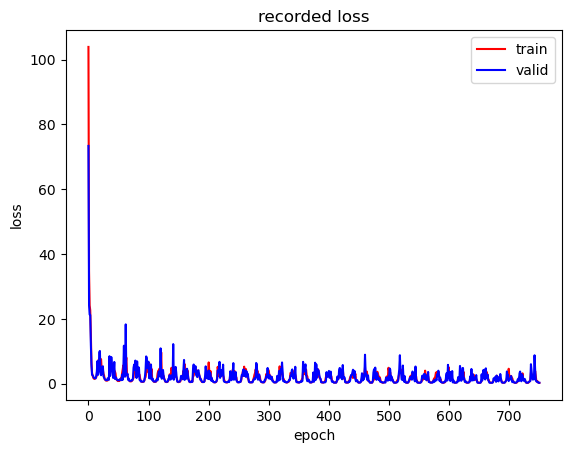

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 98.25, valid_loss: 40.45
Validation loss decreased (inf --> 40.448611).  Saving model ...
[Epoch 2/1000] train_loss: 22.04, valid_loss: 18.75
Validation loss decreased (40.448611 --> 18.749296).  Saving model ...
[Epoch 3/1000] train_loss: 12.49, valid_loss: 4.68
Validation loss decreased (18.749296 --> 4.676833).  Saving model ...
[Epoch 4/1000] train_loss: 5.52, valid_loss: 7.80
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 4.94, valid_loss: 5.59
EarlyStopping counter: 2 out of 100
[Epoch 6/1000] train_loss: 3.45, valid_loss: 3.31
Validation loss decreased (4.676833 --> 3.306548).  Saving model ...
[Epoch 7/1000] train_loss: 2.61, valid_loss: 1.36
Validation loss decreased (3.306548 --> 1.355001).  Saving model ...
[Epoch 8/1000] train_loss: 1.59, valid_loss: 1.92
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 1.30, valid_loss: 1.30
Validation loss decreased (1.355001 --> 1.297699).  Saving model ...

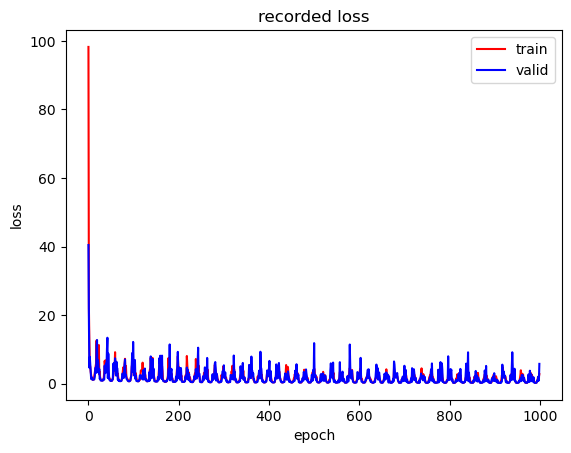

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 101.80, valid_loss: 46.69
Validation loss decreased (inf --> 46.694650).  Saving model ...
[Epoch 2/1000] train_loss: 30.29, valid_loss: 24.94
Validation loss decreased (46.694650 --> 24.943526).  Saving model ...
[Epoch 3/1000] train_loss: 20.45, valid_loss: 13.05
Validation loss decreased (24.943526 --> 13.048620).  Saving model ...
[Epoch 4/1000] train_loss: 8.16, valid_loss: 6.60
Validation loss decreased (13.048620 --> 6.603179).  Saving model ...
[Epoch 5/1000] train_loss: 4.21, valid_loss: 4.19
Validation loss decreased (6.603179 --> 4.194011).  Saving model ...
[Epoch 6/1000] train_loss: 5.91, valid_loss: 3.40
Validation loss decreased (4.194011 --> 3.403016).  Saving model ...
[Epoch 7/1000] train_loss: 2.90, valid_loss: 1.97
Validation loss decreased (3.403016 --> 1.972655).  Saving model ...
[Epoch 8/1000] train_loss: 1.90, valid_loss: 1.34
Validation loss decreased (1.972655 --> 1.344746).  Saving model ...
[Epoch 9/1000] 

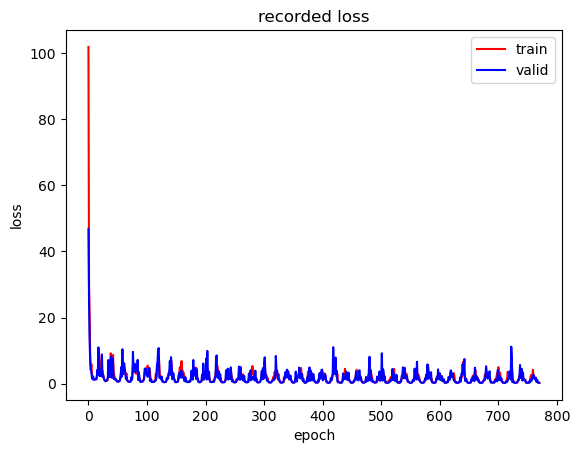

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 96.53, valid_loss: 46.00
Validation loss decreased (inf --> 46.004897).  Saving model ...
[Epoch 2/1000] train_loss: 26.72, valid_loss: 19.06
Validation loss decreased (46.004897 --> 19.060410).  Saving model ...
[Epoch 3/1000] train_loss: 13.56, valid_loss: 10.27
Validation loss decreased (19.060410 --> 10.273260).  Saving model ...
[Epoch 4/1000] train_loss: 6.05, valid_loss: 4.93
Validation loss decreased (10.273260 --> 4.928947).  Saving model ...
[Epoch 5/1000] train_loss: 4.78, valid_loss: 4.09
Validation loss decreased (4.928947 --> 4.087430).  Saving model ...
[Epoch 6/1000] train_loss: 2.97, valid_loss: 2.52
Validation loss decreased (4.087430 --> 2.516806).  Saving model ...
[Epoch 7/1000] train_loss: 2.36, valid_loss: 2.31
Validation loss decreased (2.516806 --> 2.309413).  Saving model ...
[Epoch 8/1000] train_loss: 2.11, valid_loss: 1.91
Validation loss decreased (2.309413 --> 1.912098).  Saving model ...
[Epoch 9/1000] t

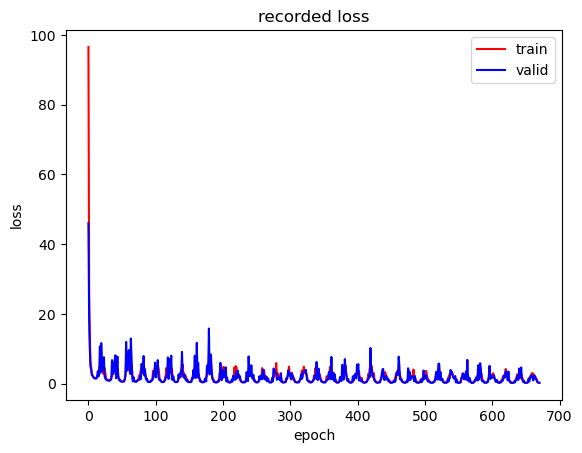

Averge RMSE performance: 0.26621663222710296
Size: 5000
Fold 1
cuda is available
[Epoch 1/1000] train_loss: 62.90, valid_loss: 11.68
Validation loss decreased (inf --> 11.680450).  Saving model ...
[Epoch 2/1000] train_loss: 8.16, valid_loss: 13.73
EarlyStopping counter: 1 out of 100
[Epoch 3/1000] train_loss: 5.79, valid_loss: 5.25
Validation loss decreased (11.680450 --> 5.253039).  Saving model ...
[Epoch 4/1000] train_loss: 5.82, valid_loss: 9.36
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 4.98, valid_loss: 3.81
Validation loss decreased (5.253039 --> 3.808053).  Saving model ...
[Epoch 6/1000] train_loss: 3.52, valid_loss: 2.48
Validation loss decreased (3.808053 --> 2.478427).  Saving model ...
[Epoch 7/1000] train_loss: 1.97, valid_loss: 1.91
Validation loss decreased (2.478427 --> 1.906357).  Saving model ...
[Epoch 8/1000] train_loss: 1.31, valid_loss: 1.47
Validation loss decreased (1.906357 --> 1.473097).  Saving model ...
[Epoch 9/1000] train_loss: 1.06, 

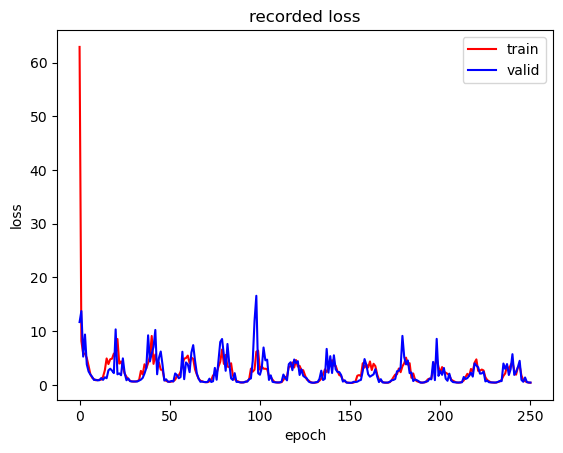

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 88.97, valid_loss: 31.66
Validation loss decreased (inf --> 31.661481).  Saving model ...
[Epoch 2/1000] train_loss: 21.85, valid_loss: 8.82
Validation loss decreased (31.661481 --> 8.823436).  Saving model ...
[Epoch 3/1000] train_loss: 10.11, valid_loss: 5.39
Validation loss decreased (8.823436 --> 5.392334).  Saving model ...
[Epoch 4/1000] train_loss: 6.51, valid_loss: 3.67
Validation loss decreased (5.392334 --> 3.674872).  Saving model ...
[Epoch 5/1000] train_loss: 7.01, valid_loss: 4.34
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 2.77, valid_loss: 2.27
Validation loss decreased (3.674872 --> 2.271761).  Saving model ...
[Epoch 7/1000] train_loss: 2.55, valid_loss: 1.50
Validation loss decreased (2.271761 --> 1.499117).  Saving model ...
[Epoch 8/1000] train_loss: 2.16, valid_loss: 2.82
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 1.68, valid_loss: 1.34
Validation loss decreased (1.499117 --

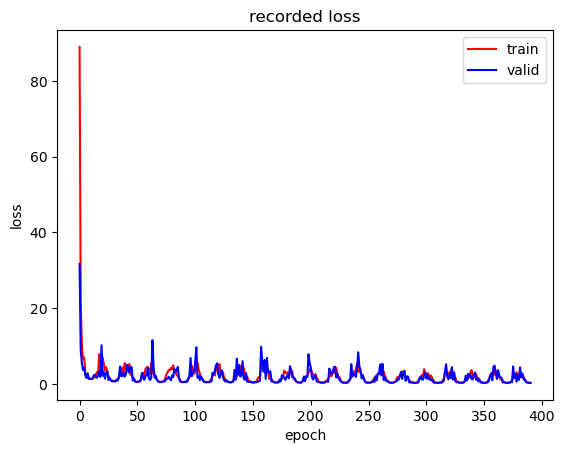

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 79.93, valid_loss: 26.71
Validation loss decreased (inf --> 26.706623).  Saving model ...
[Epoch 2/1000] train_loss: 25.70, valid_loss: 18.03
Validation loss decreased (26.706623 --> 18.027359).  Saving model ...
[Epoch 3/1000] train_loss: 13.08, valid_loss: 20.90
EarlyStopping counter: 1 out of 100
[Epoch 4/1000] train_loss: 7.18, valid_loss: 5.03
Validation loss decreased (18.027359 --> 5.032216).  Saving model ...
[Epoch 5/1000] train_loss: 4.89, valid_loss: 2.33
Validation loss decreased (5.032216 --> 2.327022).  Saving model ...
[Epoch 6/1000] train_loss: 3.30, valid_loss: 1.67
Validation loss decreased (2.327022 --> 1.665573).  Saving model ...
[Epoch 7/1000] train_loss: 2.10, valid_loss: 3.57
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 1.57, valid_loss: 1.50
Validation loss decreased (1.665573 --> 1.502002).  Saving model ...
[Epoch 9/1000] train_loss: 1.03, valid_loss: 0.91
Validation loss decreased (1.50200

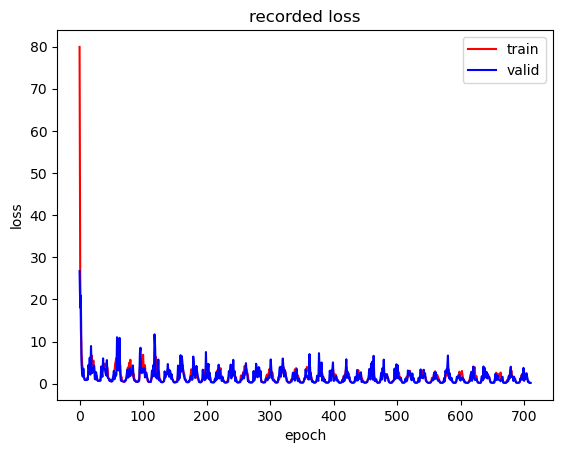

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 74.32, valid_loss: 19.75
Validation loss decreased (inf --> 19.750166).  Saving model ...
[Epoch 2/1000] train_loss: 10.61, valid_loss: 11.87
Validation loss decreased (19.750166 --> 11.867536).  Saving model ...
[Epoch 3/1000] train_loss: 5.65, valid_loss: 9.26
Validation loss decreased (11.867536 --> 9.258262).  Saving model ...
[Epoch 4/1000] train_loss: 4.65, valid_loss: 2.34
Validation loss decreased (9.258262 --> 2.337490).  Saving model ...
[Epoch 5/1000] train_loss: 4.03, valid_loss: 3.46
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 3.30, valid_loss: 2.39
EarlyStopping counter: 2 out of 100
[Epoch 7/1000] train_loss: 2.05, valid_loss: 2.61
EarlyStopping counter: 3 out of 100
[Epoch 8/1000] train_loss: 1.68, valid_loss: 1.65
Validation loss decreased (2.337490 --> 1.648574).  Saving model ...
[Epoch 9/1000] train_loss: 1.28, valid_loss: 1.35
Validation loss decreased (1.648574 --> 1.347321).  Saving model ...


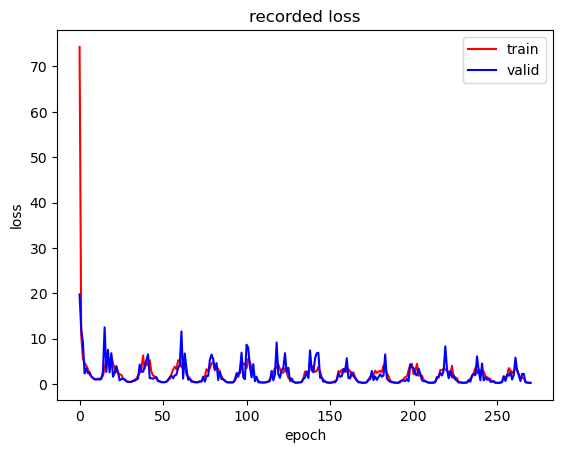

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 71.74, valid_loss: 21.65
Validation loss decreased (inf --> 21.652047).  Saving model ...
[Epoch 2/1000] train_loss: 11.51, valid_loss: 8.15
Validation loss decreased (21.652047 --> 8.147408).  Saving model ...
[Epoch 3/1000] train_loss: 5.25, valid_loss: 4.01
Validation loss decreased (8.147408 --> 4.008639).  Saving model ...
[Epoch 4/1000] train_loss: 5.21, valid_loss: 5.10
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 4.19, valid_loss: 2.52
Validation loss decreased (4.008639 --> 2.517074).  Saving model ...
[Epoch 6/1000] train_loss: 2.92, valid_loss: 2.27
Validation loss decreased (2.517074 --> 2.272720).  Saving model ...
[Epoch 7/1000] train_loss: 2.28, valid_loss: 1.66
Validation loss decreased (2.272720 --> 1.658845).  Saving model ...
[Epoch 8/1000] train_loss: 1.65, valid_loss: 1.45
Validation loss decreased (1.658845 --> 1.454932).  Saving model ...
[Epoch 9/1000] train_loss: 1.38, valid_loss: 1.21
Valida

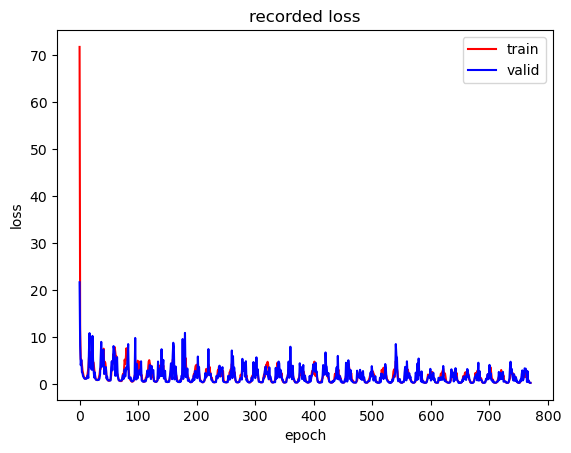

Averge RMSE performance: 0.26270553514361383


In [ ]:
size_lst = [100, 500, 1000, 3000, 5000]
avg_loss_lst2 = []

for size in size_lst:
    # Kfold
    splits=KFold(n_splits=5, shuffle=True, random_state=100)
    kfold_history = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

    np.random.seed(0)
    v0 = np.random.uniform(low=1, high=100, size=size) # 1-100
    theta = np.random.uniform(low=1, high=90, size=size) # 1-90

    # calculate true max_height, max_length (targets)
    max_h = max_height(v0, theta) # 斜拋最大高度
    max_l = max_length(v0, theta) # 斜拋最大距離

    # concate data
    x_data = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
    y_data = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)
    # load dataset
    train_dataset = Projectile_Dataset(x_data, y_data, pred_target='max_height')
    test_dataset = Projectile_Dataset(x_data, y_data, pred_target='max_height')
    print('Size: '+str(size))

    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(x_data.shape[0]))):
        print(f'Fold {fold+1}')

        # initiate data loader
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(train_dataset, batch_size=50, sampler=train_sampler) # batch_size : 要分批餵入模型的資料大小
        test_loader = DataLoader(test_dataset, batch_size=50, sampler=test_sampler)

        # initiate model
        maxh_model = MaxH_DNN(activation_func='LeakyReLU')

        # train
        saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

        # draw loss plot
        loss_plot(train_loss, valid_loss)

        # save history
        kfold_history['model'].append(saved_model)
        kfold_history['train_idx'].append(train_idx)
        kfold_history['test_idx'].append(val_idx)
        kfold_history['train_min_loss'].append(np.min(train_loss))
        kfold_history['test_min_loss'].append(np.min(valid_loss))
    avg_rmse = np.mean(kfold_history['test_min_loss'])
    avg_loss_lst2.append(avg_rmse)
    print('Averge RMSE performance: '+str(avg_rmse))


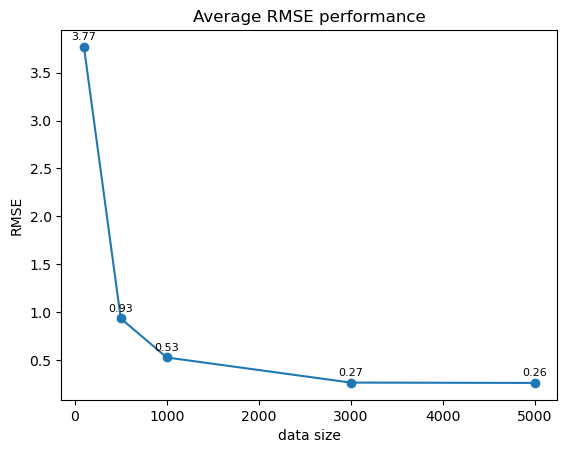

In [120]:
plt.figure()
plt.plot(size_lst, avg_loss_lst2, '-o')
for a,b in zip(size_lst, avg_loss_lst2):
    plt.text(a, b+0.05, '%.2f' % b, ha='center', va= 'bottom',fontsize=8)
plt.title('Average RMSE performance')
plt.ylabel('RMSE')
plt.xlabel('data size')
plt.show()

# max_height train & evaluate

Fold 1
cuda is available
[Epoch 1/1000] train_loss: 89.46, valid_loss: 29.31
Validation loss decreased (inf --> 29.313398).  Saving model ...
[Epoch 2/1000] train_loss: 25.94, valid_loss: 19.53
Validation loss decreased (29.313398 --> 19.534416).  Saving model ...
[Epoch 3/1000] train_loss: 20.03, valid_loss: 15.24
Validation loss decreased (19.534416 --> 15.235832).  Saving model ...
[Epoch 4/1000] train_loss: 12.33, valid_loss: 7.29
Validation loss decreased (15.235832 --> 7.293511).  Saving model ...
[Epoch 5/1000] train_loss: 5.20, valid_loss: 3.74
Validation loss decreased (7.293511 --> 3.741901).  Saving model ...
[Epoch 6/1000] train_loss: 4.49, valid_loss: 2.06
Validation loss decreased (3.741901 --> 2.056456).  Saving model ...
[Epoch 7/1000] train_loss: 2.93, valid_loss: 3.96
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 2.36, valid_loss: 2.80
EarlyStopping counter: 2 out of 100
[Epoch 9/1000] train_loss: 1.90, valid_loss: 1.36
Validation loss decreased (2.05

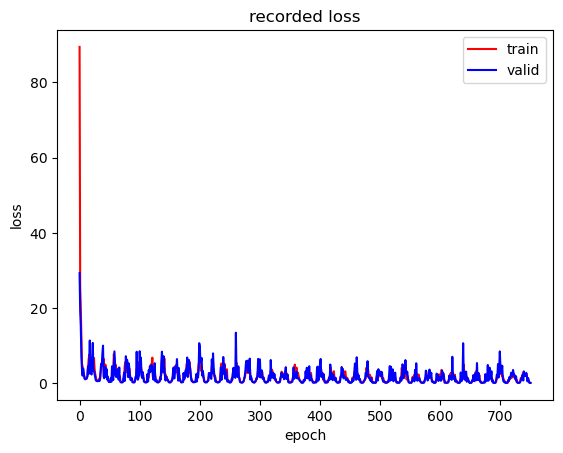

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 101.28, valid_loss: 55.72
Validation loss decreased (inf --> 55.720201).  Saving model ...
[Epoch 2/1000] train_loss: 32.01, valid_loss: 21.11
Validation loss decreased (55.720201 --> 21.111524).  Saving model ...
[Epoch 3/1000] train_loss: 20.42, valid_loss: 15.77
Validation loss decreased (21.111524 --> 15.767665).  Saving model ...
[Epoch 4/1000] train_loss: 14.47, valid_loss: 9.76
Validation loss decreased (15.767665 --> 9.758948).  Saving model ...
[Epoch 5/1000] train_loss: 6.97, valid_loss: 4.55
Validation loss decreased (9.758948 --> 4.549829).  Saving model ...
[Epoch 6/1000] train_loss: 4.21, valid_loss: 3.27
Validation loss decreased (4.549829 --> 3.266389).  Saving model ...
[Epoch 7/1000] train_loss: 3.47, valid_loss: 4.23
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 2.68, valid_loss: 2.36
Validation loss decreased (3.266389 --> 2.363242).  Saving model ...
[Epoch 9/1000] train_loss: 2.30, valid_loss: 2.

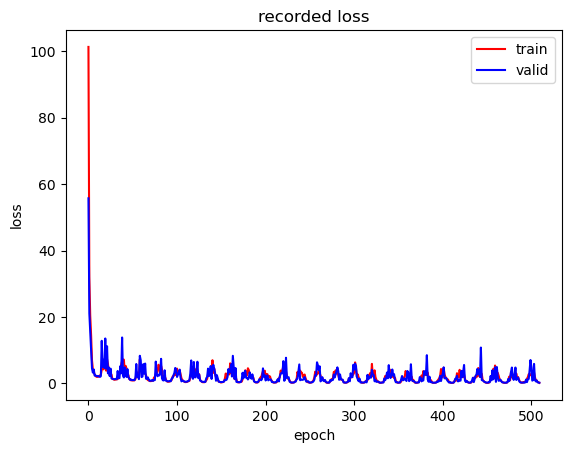

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 96.75, valid_loss: 29.61
Validation loss decreased (inf --> 29.608501).  Saving model ...
[Epoch 2/1000] train_loss: 28.45, valid_loss: 24.92
Validation loss decreased (29.608501 --> 24.920531).  Saving model ...
[Epoch 3/1000] train_loss: 23.59, valid_loss: 21.21
Validation loss decreased (24.920531 --> 21.206220).  Saving model ...
[Epoch 4/1000] train_loss: 20.32, valid_loss: 18.10
Validation loss decreased (21.206220 --> 18.095224).  Saving model ...
[Epoch 5/1000] train_loss: 14.21, valid_loss: 9.56
Validation loss decreased (18.095224 --> 9.555123).  Saving model ...
[Epoch 6/1000] train_loss: 8.57, valid_loss: 6.45
Validation loss decreased (9.555123 --> 6.451490).  Saving model ...
[Epoch 7/1000] train_loss: 6.61, valid_loss: 7.29
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 5.00, valid_loss: 4.05
Validation loss decreased (6.451490 --> 4.046162).  Saving model ...
[Epoch 9/1000] train_loss: 4.12, valid_loss:

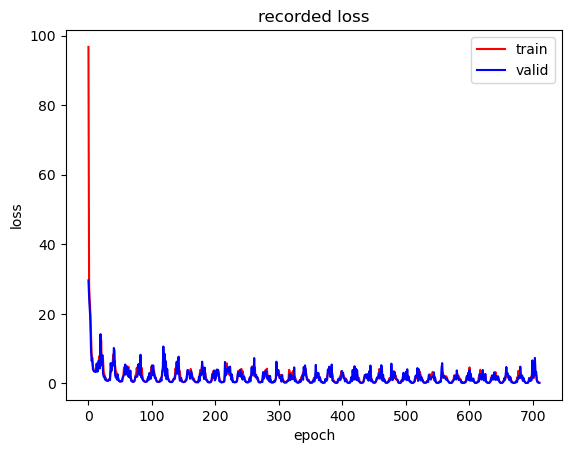

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 93.05, valid_loss: 36.10
Validation loss decreased (inf --> 36.098567).  Saving model ...
[Epoch 2/1000] train_loss: 26.27, valid_loss: 28.36
Validation loss decreased (36.098567 --> 28.358911).  Saving model ...
[Epoch 3/1000] train_loss: 23.16, valid_loss: 19.13
Validation loss decreased (28.358911 --> 19.128009).  Saving model ...
[Epoch 4/1000] train_loss: 13.23, valid_loss: 6.64
Validation loss decreased (19.128009 --> 6.637895).  Saving model ...
[Epoch 5/1000] train_loss: 7.48, valid_loss: 6.01
Validation loss decreased (6.637895 --> 6.011032).  Saving model ...
[Epoch 6/1000] train_loss: 5.03, valid_loss: 5.92
Validation loss decreased (6.011032 --> 5.923538).  Saving model ...
[Epoch 7/1000] train_loss: 4.11, valid_loss: 3.63
Validation loss decreased (5.923538 --> 3.634984).  Saving model ...
[Epoch 8/1000] train_loss: 3.04, valid_loss: 2.33
Validation loss decreased (3.634984 --> 2.331173).  Saving model ...
[Epoch 9/1000] 

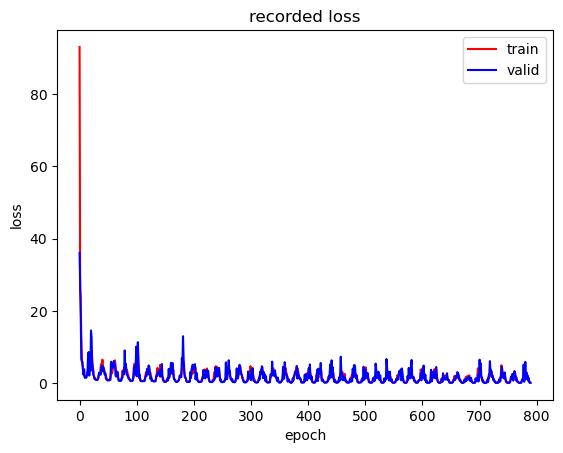

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 92.38, valid_loss: 30.82
Validation loss decreased (inf --> 30.818339).  Saving model ...
[Epoch 2/1000] train_loss: 27.23, valid_loss: 30.70
Validation loss decreased (30.818339 --> 30.695770).  Saving model ...
[Epoch 3/1000] train_loss: 20.28, valid_loss: 23.71
Validation loss decreased (30.695770 --> 23.708965).  Saving model ...
[Epoch 4/1000] train_loss: 12.75, valid_loss: 6.91
Validation loss decreased (23.708965 --> 6.907411).  Saving model ...
[Epoch 5/1000] train_loss: 5.46, valid_loss: 6.45
Validation loss decreased (6.907411 --> 6.448316).  Saving model ...
[Epoch 6/1000] train_loss: 3.33, valid_loss: 2.52
Validation loss decreased (6.448316 --> 2.519769).  Saving model ...
[Epoch 7/1000] train_loss: 2.77, valid_loss: 3.63
EarlyStopping counter: 1 out of 100
[Epoch 8/1000] train_loss: 2.05, valid_loss: 1.94
Validation loss decreased (2.519769 --> 1.944135).  Saving model ...
[Epoch 9/1000] train_loss: 1.13, valid_loss: 1.0

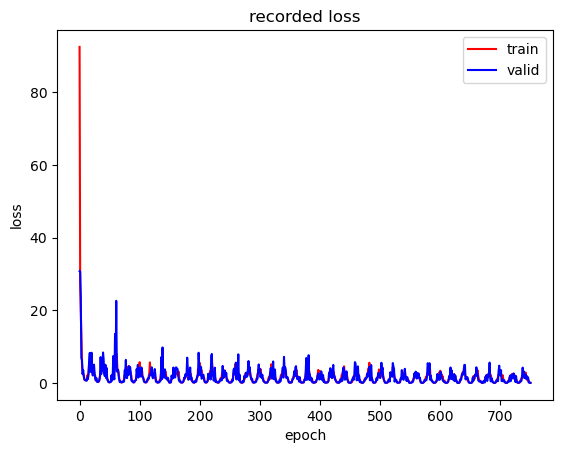

In [96]:
# Kfold
splits=KFold(n_splits=5, shuffle=True, random_state=100)
kfold_history = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

# load dataset
train_dataset = Projectile_Dataset(X, Y, pred_target='max_height')
test_dataset = Projectile_Dataset(X, Y, pred_target='max_height')

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(X.shape[0]))):
    print(f'Fold {fold+1}')

    # initiate data loader
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=50, sampler=train_sampler) # batch_size : 要分批餵入模型的資料大小
    test_loader = DataLoader(test_dataset, batch_size=50, sampler=test_sampler)

    # initiate model
    maxh_model = MaxH_DNN(activation_func='Mish')

    # train
    saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

    # draw loss plot
    loss_plot(train_loss, valid_loss)

    # save history
    kfold_history['model'].append(saved_model)
    kfold_history['train_idx'].append(train_idx)
    kfold_history['test_idx'].append(val_idx)
    kfold_history['train_min_loss'].append(np.min(train_loss))
    kfold_history['test_min_loss'].append(np.min(valid_loss))

## 5-fold cross-validation

Mean RMSE: 0.14206341840326783
Max RMSE: 0.223275450989604
Min RMSE: 0.11563033858935039


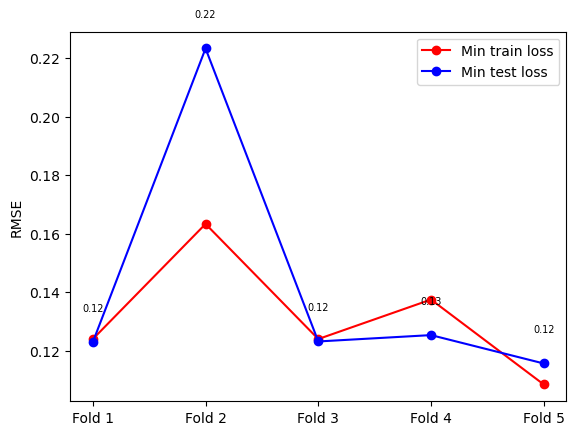

In [97]:
# 比較各fold的訓練結果
train_min_loss = kfold_history['train_min_loss']
test_min_loss = kfold_history['test_min_loss']
fold_num = ['Fold '+str(i+1) for i in range(5)]

print('Mean RMSE: '+str(np.mean(test_min_loss)))
print('Max RMSE: '+str(np.max(test_min_loss)))
print('Min RMSE: '+str(np.min(test_min_loss)))

plt.plot(fold_num, train_min_loss, 'ro-', label='Min train loss')
plt.plot(fold_num, test_min_loss, 'bo-', label='Min test loss')
for a,b in zip(fold_num, test_min_loss):
    plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylabel('RMSE')
plt.legend()
plt.show()

cuda is available
Training set|RMSE: 0.11, R2: 0.999998927116394
Testing set|RMSE: 0.12, R2: 0.999998927116394


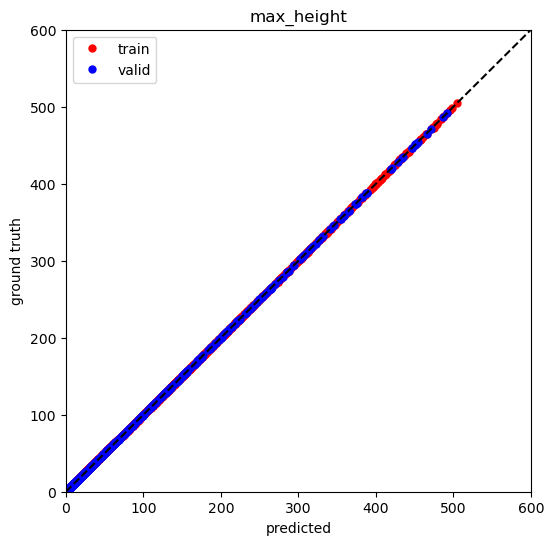

In [98]:
# 以test error最低的模型為最佳模型
best_result_idx = np.argmin(test_min_loss)

# 取得該模型的資料
best_maxh_model = kfold_history['model'][best_result_idx]
best_train_idx = kfold_history['train_idx'][best_result_idx]
best_test_idx = kfold_history['test_idx'][best_result_idx]

train_sampler = SubsetRandomSampler(best_train_idx)
test_sampler = SubsetRandomSampler(best_test_idx)
train_loader = DataLoader(train_dataset, batch_size=800, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=200, sampler=test_sampler)

test_true, test_pred = model_evaluate(best_maxh_model, train_loader, test_loader)

<AxesSubplot:xlabel='x', ylabel='y'>

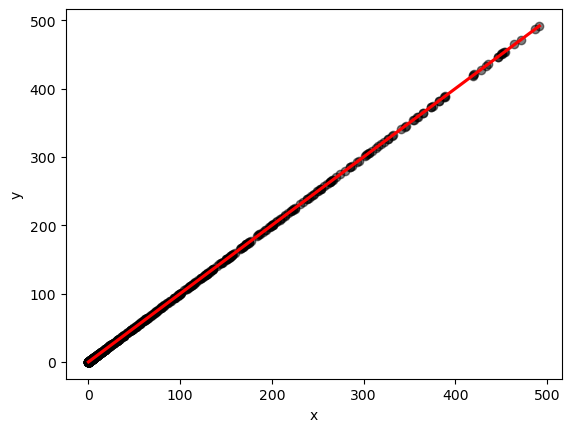

In [99]:
# 要畫信賴區間的圖但準確率太高看不出來
regplot_df = pd.DataFrame({'x': test_true, 'y': test_pred})
sns.regplot(x='x', y='y', data=regplot_df,
                          scatter_kws={'color':'black', 'alpha':0.5},
                          line_kws={'color':'red'},
                          ci=95)
# sns.lineplot(x='y', y='y', data=regplot_df, dashes=(2, 2))

## 3D plot

C:\Users\User\AppData\Local\Temp\ipykernel_24692\2170955616.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


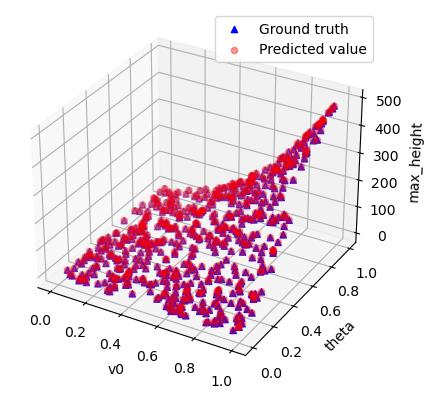

In [117]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = [], []
true, pred = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs = inputs
        targets = targets
        outputs = best_maxh_model.cpu()(inputs)
        
        x1.append(inputs[:,0].numpy())
        x2.append(inputs[:,1].numpy())
        true.append(targets.numpy())
        pred.append(outputs.numpy())

ax.scatter(x1, x2, true, marker='^', color='blue', label='Ground truth')
ax.scatter(x1, x2, pred, marker='o', color='red', label='Predicted value', alpha=0.4)
ax.legend()
ax.set_xlabel('v0')
ax.set_ylabel('theta')
ax.set_zlabel('max_height')
plt.show()

# max_length train & evaluate

Fold 1
cuda is available
[Epoch 1/1000] train_loss: 232.07, valid_loss: 137.60
Validation loss decreased (inf --> 137.603250).  Saving model ...
[Epoch 2/1000] train_loss: 137.92, valid_loss: 131.25
Validation loss decreased (137.603250 --> 131.254508).  Saving model ...
[Epoch 3/1000] train_loss: 114.74, valid_loss: 70.66
Validation loss decreased (131.254508 --> 70.661607).  Saving model ...
[Epoch 4/1000] train_loss: 53.77, valid_loss: 40.55
Validation loss decreased (70.661607 --> 40.547067).  Saving model ...
[Epoch 5/1000] train_loss: 34.65, valid_loss: 42.21
EarlyStopping counter: 1 out of 100
[Epoch 6/1000] train_loss: 28.24, valid_loss: 17.45
Validation loss decreased (40.547067 --> 17.454063).  Saving model ...
[Epoch 7/1000] train_loss: 17.40, valid_loss: 9.69
Validation loss decreased (17.454063 --> 9.690232).  Saving model ...
[Epoch 8/1000] train_loss: 15.59, valid_loss: 16.42
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 14.12, valid_loss: 14.13
EarlySto

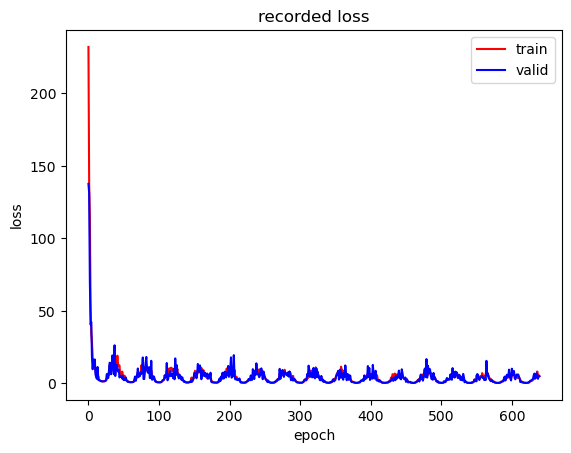

Fold 2
cuda is available
[Epoch 1/1000] train_loss: 238.61, valid_loss: 176.19
Validation loss decreased (inf --> 176.185425).  Saving model ...
[Epoch 2/1000] train_loss: 142.30, valid_loss: 135.50
Validation loss decreased (176.185425 --> 135.495906).  Saving model ...
[Epoch 3/1000] train_loss: 95.28, valid_loss: 50.50
Validation loss decreased (135.495906 --> 50.502459).  Saving model ...
[Epoch 4/1000] train_loss: 42.29, valid_loss: 53.43
EarlyStopping counter: 1 out of 100
[Epoch 5/1000] train_loss: 33.72, valid_loss: 44.10
Validation loss decreased (50.502459 --> 44.104922).  Saving model ...
[Epoch 6/1000] train_loss: 32.52, valid_loss: 16.76
Validation loss decreased (44.104922 --> 16.760361).  Saving model ...
[Epoch 7/1000] train_loss: 22.99, valid_loss: 11.31
Validation loss decreased (16.760361 --> 11.306827).  Saving model ...
[Epoch 8/1000] train_loss: 11.67, valid_loss: 7.57
Validation loss decreased (11.306827 --> 7.572249).  Saving model ...
[Epoch 9/1000] train_loss:

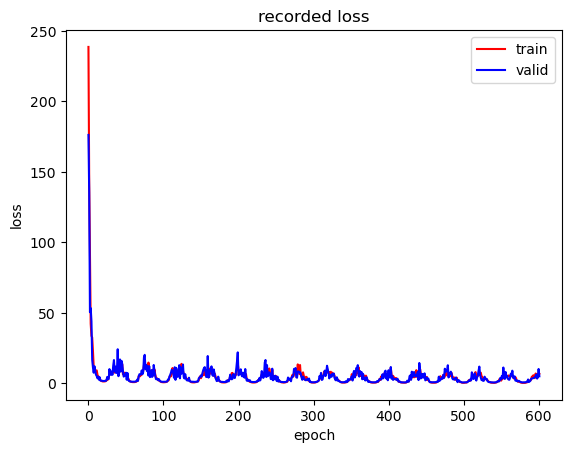

Fold 3
cuda is available
[Epoch 1/1000] train_loss: 246.31, valid_loss: 158.70
Validation loss decreased (inf --> 158.697366).  Saving model ...
[Epoch 2/1000] train_loss: 149.25, valid_loss: 134.24
Validation loss decreased (158.697366 --> 134.239125).  Saving model ...
[Epoch 3/1000] train_loss: 140.91, valid_loss: 131.56
Validation loss decreased (134.239125 --> 131.557899).  Saving model ...
[Epoch 4/1000] train_loss: 136.20, valid_loss: 112.30
Validation loss decreased (131.557899 --> 112.298281).  Saving model ...
[Epoch 5/1000] train_loss: 76.86, valid_loss: 54.53
Validation loss decreased (112.298281 --> 54.533606).  Saving model ...
[Epoch 6/1000] train_loss: 38.32, valid_loss: 27.55
Validation loss decreased (54.533606 --> 27.552625).  Saving model ...
[Epoch 7/1000] train_loss: 27.64, valid_loss: 17.91
Validation loss decreased (27.552625 --> 17.914113).  Saving model ...
[Epoch 8/1000] train_loss: 14.76, valid_loss: 8.11
Validation loss decreased (17.914113 --> 8.108615).  

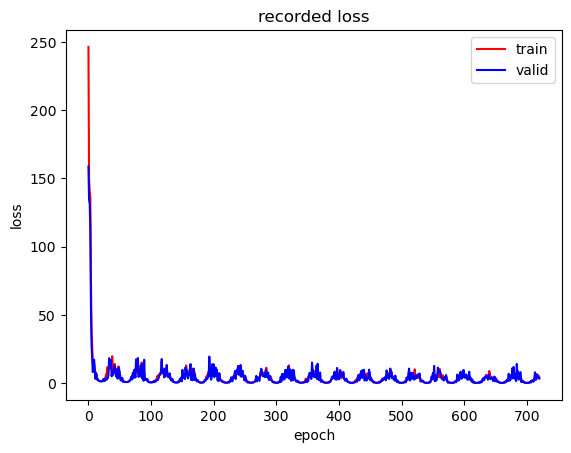

Fold 4
cuda is available
[Epoch 1/1000] train_loss: 243.42, valid_loss: 202.30
Validation loss decreased (inf --> 202.301818).  Saving model ...
[Epoch 2/1000] train_loss: 155.02, valid_loss: 148.41
Validation loss decreased (202.301818 --> 148.410056).  Saving model ...
[Epoch 3/1000] train_loss: 146.58, valid_loss: 139.36
Validation loss decreased (148.410056 --> 139.355599).  Saving model ...
[Epoch 4/1000] train_loss: 135.92, valid_loss: 132.10
Validation loss decreased (139.355599 --> 132.098150).  Saving model ...
[Epoch 5/1000] train_loss: 116.27, valid_loss: 68.04
Validation loss decreased (132.098150 --> 68.037829).  Saving model ...
[Epoch 6/1000] train_loss: 59.22, valid_loss: 51.41
Validation loss decreased (68.037829 --> 51.407159).  Saving model ...
[Epoch 7/1000] train_loss: 42.38, valid_loss: 30.74
Validation loss decreased (51.407159 --> 30.739014).  Saving model ...
[Epoch 8/1000] train_loss: 28.37, valid_loss: 18.74
Validation loss decreased (30.739014 --> 18.744948)

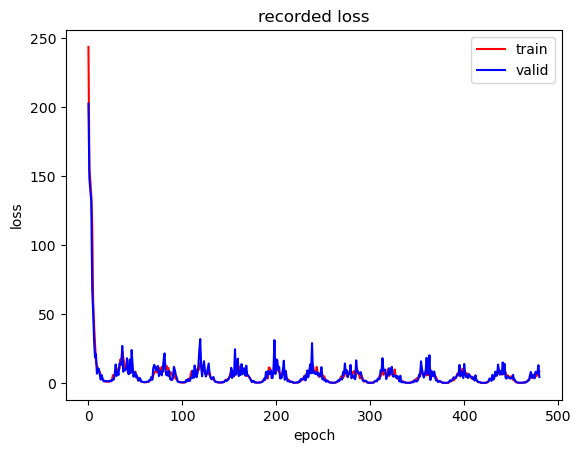

Fold 5
cuda is available
[Epoch 1/1000] train_loss: 244.04, valid_loss: 151.31
Validation loss decreased (inf --> 151.313483).  Saving model ...
[Epoch 2/1000] train_loss: 149.23, valid_loss: 142.51
Validation loss decreased (151.313483 --> 142.511617).  Saving model ...
[Epoch 3/1000] train_loss: 137.67, valid_loss: 141.01
Validation loss decreased (142.511617 --> 141.010389).  Saving model ...
[Epoch 4/1000] train_loss: 135.68, valid_loss: 126.69
Validation loss decreased (141.010389 --> 126.694242).  Saving model ...
[Epoch 5/1000] train_loss: 83.73, valid_loss: 42.34
Validation loss decreased (126.694242 --> 42.344977).  Saving model ...
[Epoch 6/1000] train_loss: 39.76, valid_loss: 29.39
Validation loss decreased (42.344977 --> 29.392242).  Saving model ...
[Epoch 7/1000] train_loss: 21.83, valid_loss: 25.38
Validation loss decreased (29.392242 --> 25.381735).  Saving model ...
[Epoch 8/1000] train_loss: 22.04, valid_loss: 13.44
Validation loss decreased (25.381735 --> 13.439493).

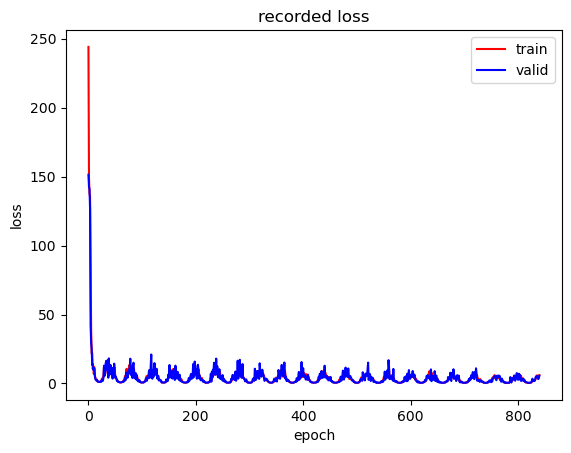

In [103]:
# Kfold
splits=KFold(n_splits=5, shuffle=True, random_state=100)
kfold_history_L = {'model':[], 'train_idx':[], 'test_idx': [], 'train_min_loss':[], 'test_min_loss':[]}

# load dataset
train_dataset_L = Projectile_Dataset(X, Y, pred_target='max_length')
test_dataset_L = Projectile_Dataset(X, Y, pred_target='max_length')

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(X.shape[0]))):
    print(f'Fold {fold+1}')

    # initiate data loader
    train_sampler_L = SubsetRandomSampler(train_idx)
    test_sampler_L = SubsetRandomSampler(val_idx)
    train_loader_L = DataLoader(train_dataset_L, batch_size=50, sampler=train_sampler_L) # batch_size : 要分批餵入模型的資料大小
    test_loader_L = DataLoader(test_dataset_L, batch_size=50, sampler=test_sampler_L)

    # initiate model
    maxl_model = MaxL_DNN(activation_func='Mish')

    saved_model_L, train_loss_L, valid_loss_L = train_model(maxl_model, train_loader_L, test_loader_L, num_epochs=1000, lr=5*1e-3, weight_decay=1e-6, T_max=20, eta_min=1e-6, patience=100)

    # draw loss plot
    loss_plot(train_loss_L, valid_loss_L)

    # save history
    kfold_history_L['model'].append(saved_model_L)
    kfold_history_L['train_idx'].append(train_idx)
    kfold_history_L['test_idx'].append(val_idx)
    kfold_history_L['train_min_loss'].append(np.min(train_loss_L))
    kfold_history_L['test_min_loss'].append(np.min(valid_loss_L))

# 5-fold cross-validation

Mean RMSE: 0.39449801519513134
Max RMSE: 0.6478019629915556
Min RMSE: 0.2372884377837181


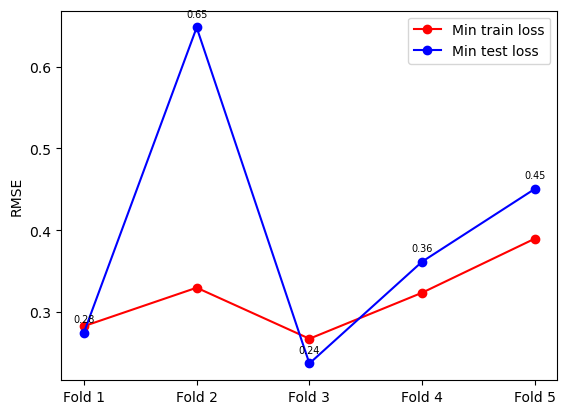

In [104]:
# 比較各fold的訓練結果
train_min_loss = kfold_history_L['train_min_loss']
test_min_loss = kfold_history_L['test_min_loss']
fold_num = ['Fold '+str(i+1) for i in range(5)]

print('Mean RMSE: '+str(np.mean(test_min_loss)))
print('Max RMSE: '+str(np.max(test_min_loss)))
print('Min RMSE: '+str(np.min(test_min_loss)))

plt.plot(fold_num, train_min_loss, 'ro-', label='Min train loss')
plt.plot(fold_num, test_min_loss, 'bo-', label='Min test loss')
for a,b in zip(fold_num, test_min_loss):
    plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylabel('RMSE')
plt.legend()
plt.show()

cuda is available
Training set|RMSE: 0.27, R2: 0.9999987880388895
Testing set|RMSE: 0.24, R2: 0.9999989072481791


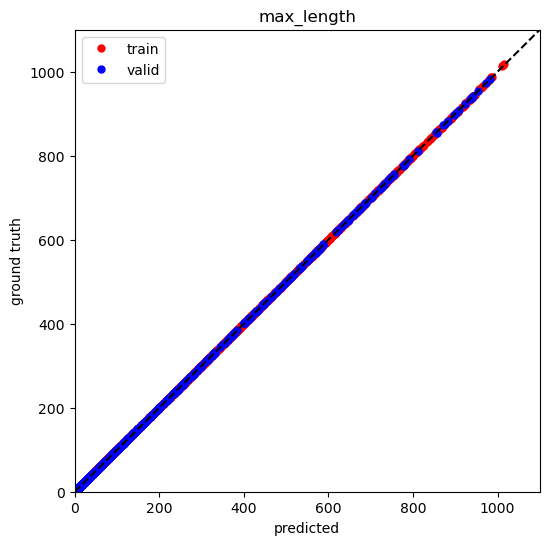

In [105]:
# 以test error最低的模型為最佳模型
best_result_idx = np.argmin(test_min_loss)

# 取得該模型的資料
best_maxl_model = kfold_history_L['model'][best_result_idx]
best_train_idx = kfold_history_L['train_idx'][best_result_idx]
best_test_idx = kfold_history_L['test_idx'][best_result_idx]

train_sampler_L = SubsetRandomSampler(best_train_idx)
test_sampler_L = SubsetRandomSampler(best_test_idx)
train_loader_L = DataLoader(train_dataset_L, batch_size=800, sampler=train_sampler_L)
test_loader_L = DataLoader(test_dataset_L, batch_size=200, sampler=test_sampler_L)

test_true_L, test_pred_L = model_evaluate(best_maxl_model, train_loader_L, test_loader_L, pred_target='max_length')

<AxesSubplot:xlabel='x', ylabel='y'>

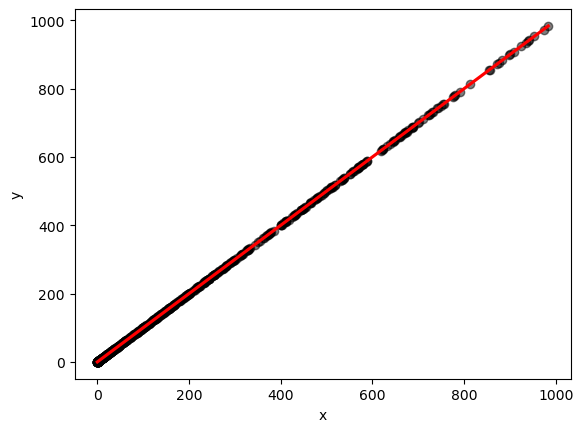

In [106]:
# 要畫信賴區間的圖但準確率太高看不出來
regplot_df = pd.DataFrame({'x': test_true_L, 'y': test_pred_L})
sns.regplot(x='x', y='y', data=regplot_df,
                          scatter_kws={'color':'black', 'alpha':0.5},
                          line_kws={'color':'red'},
                          ci=95)

## 3D plot

C:\Users\User\AppData\Local\Temp\ipykernel_24692\3960710129.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


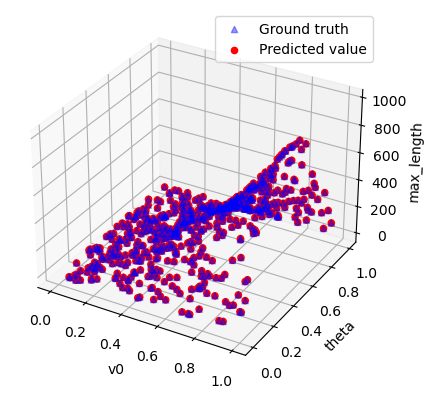

In [119]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = [], []
true, pred = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader_L):
        inputs = inputs
        targets = targets
        outputs = best_maxl_model.cpu()(inputs)
        
        x1.append(inputs[:,0].numpy())
        x2.append(inputs[:,1].numpy())
        true.append(targets.numpy())
        pred.append(outputs.numpy())

ax.scatter(x1, x2, true, marker='^', color='blue', label='Ground truth', alpha=0.4)
ax.scatter(x1, x2, pred, marker='o', color='red', label='Predicted value', alpha=1)
ax.legend()
ax.set_xlabel('v0')
ax.set_ylabel('theta')
ax.set_zlabel('max_length')
plt.show()

In [14]:
# 產生資料 模型(層數設計, activation function, loss function, metrics) 訓練結果(視覺化圖, n-fold)